The dual objective is: 1) to observe how an agent using Q-learning adapts to various environments, which will progressively become more complex until reaching a casino-level blackjack table; 2) to see if the agent can replicate the results of the basic strategy. 

For those unfamiliar, the basic strategy, also known as the fundamental strategy, provides guidelines on what moves to make to maximize the chances of beating the dealer, using statistical analysis. It can be represented as a two-entry table with (sum of player's hand, dealer’s face-up card) and recommendations on whether to hit, stay, split, or double. The table typically starts at 8-9 and ends at 17, as above and below these values, there is only one valid, and smart, move to take.

Below, I will insert an image of the table, which I won’t include every time. It’s recommended to keep it open in another tab, as the result analysis will frequently refer to this table.

I don’t want to take full credit for everything, so I’ll start by saying that the code structure was initially taken from OpenAI’s Gymnasium library. This library provides numerous environments for reinforcement learning, including one for blackjack.
However, I wasn’t satisfied with how the code was managed, so I deconstructed it, kept only the core structure (the environment and agent classes, along with some pieces of code and the initial support libraries), and added the custom code I needed.

I’ve added as many comments as possible to make the code as understandable as possible, and I’ve applied the same approach to the analysis of the results. Since there are many repeated parts of code but many changes and additions, I will gradually rewrite the code and comment only on the changed parts to help the reader find the changes quickly.

During the analyses, I never stopped to talk about hyperparameters. This is because in the first 3 environments after playing so many games, except for choosing reckless values, you get more or less the same results. So, I decided to keep the same values throughout the analysis. Only in the fourth I did change the lower delta limit, favoring greater exploration. This is because the agent needed more time to understand how to behave and arrive at a valid strategy. If the reader finds it necessary, he can modify and attempt further executions, the parameters have been well described and there is no risk of breaking the agent too much.

<b>Warning: the analyzes carried out can be, and are, made on the results obtained from different executions. BUT, since each execution is influenced by random decisions, the agent can assume configurations and move in the state space in different ways, so the statements I get might seem superficial or wrong. That being said, I would like if anyone reads this project and has any corrections, advice, or improvements that might help me grow, I would appreciate it. </b>

![Basic strategy](https://www.blackjackapprenticeship.com/wp-content/uploads/2018/08/BJA_Basic_Strategy.jpg)

# Import all the required libraries

In [1]:
# This is used to store observations in the Q-table
from collections import defaultdict

# A nice training loading bar
from tqdm import tqdm

# Various libraries for graph plots
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# Play and save game every N episodes
from copy import deepcopy
from time import sleep

# This library is only used to clean up the cell output, so it's possible to comment it 
# and remove the code if, for example, is running the code from terminal
from IPython.display import clear_output

# Arrays and random elements
import numpy as np

# I still use a class from the Gymnasium library for the convenience it provides
from gymnasium import spaces

# First environment

The first environment will be very simple:
- only 2 actions allowed (hit or stay)
- simple reward function (+1 for win, +1.5 for natural blackjack, -1 for loss, 0 for tie)
- infinite deck to draw from.

A very simple but limited gaming environment compared to real casino table.

## This part of the code is filled with support functiont that are used by the enviromens

In [2]:
import numpy as np

def cmp(a: int, b: int) -> float:
    """ The cmp function is the tricky one, it computes reward based on the value of the player and dealer hand. """
    # Examples: if the player have a [8, 10] and the dealer have [7, 10]:
    #   a = 18
    #   b = 17
    #   float(a > b) = float(True) = 1.0
    #   float(a < b) = float(False) = 0.0
    #   1.0 - 0.0 = 1.0
    # Rewarded with +1.0 for winning the hand
    #
    # if the player have a [7, 10] and the dealer have [7, 10]:
    #   a = 17
    #   b = 17
    #   float(a > b) = float(False) = 0.0
    #   float(a < b) = float(False) = 0.0
    #   0.0 - 0.0 = 0.0
    # Rewarded with 0.0 for draw the hand
    #
    # Exception for the bust case, where tha value a or b will be exactly 0 by the def score(hand).
    # if the player have a [7, 10, 5] and the dealer have [7, 10]:
    #   a = 0
    #   b = 17
    #   float(a > b) = float(False) = 0.0
    #   float(a < b) = float(False) = 1.0
    #   0.0 - 1.0 = -1.0
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def draw_card() -> int:
    """ Draw a random card from the deck. """
    return int(np.random.choice(deck))

def draw_hand() -> list:
    """ Draw 2 random card from the deck and return a list of them. """
    return [draw_card(), draw_card()]

def usable_ace(hand: list) -> int:
    """' Check if the hand have a usable ace, because the ace is a 1, whe have to sum it 10 to reach the 11 value. """
    return int(1 in hand and sum(hand) + 10 <= 21)

def sum_hand(hand: list) -> int:
    """ Return current hand total. """
    if usable_ace(hand):
        return sum(hand) + 10  # If I have a usable ace, I sum 10 to the hand
    return sum(hand)

def is_bust(hand: list) -> bool:
    """ Check if the sum go above 21. """
    return sum_hand(hand) > 21

def score(hand: list) -> int:
    """ Return 0 if the sum is over 21, otherwise just the sum of the hand. """
    return 0 if is_bust(hand) else sum_hand(hand)

def is_natural(hand: list) -> bool:
    """ Check for a natural blackjack (Aces and 10). """
    return sorted(hand) == [1, 10]

## Define the environment and the q_agent

In [3]:
class BlackjackEnv():
 
    def __init__(self, natural: bool=False, sab: bool=False):
        """Initialize a blackjack environment with a fixed action space and observation space,
        the natural or S&B rules and the player's hand.
        
        Args: 
            natural: The natural blackjack rule
            sab: The Sutton and Barto blackjack rule
        """
        
        self.action_space = spaces.Discrete(2) # stay or draw

        # the observation space is made of :
        #    - all possible sum of hands the player can have 
        #    - all the possible value of the dealer card (we know only 1 card)
        #    - if ther's an usable ace (if the sum of hand > 21 then the value of the ace drop to 1)
        self.observation_space = spaces.Tuple((spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))) 

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        # player's hand
        self.player = []

        # dealer's hand
        self.dealer = []

    def step(self, action: int) -> (tuple[int, int, bool], float, bool):
        """ The environment evolves based on the action taken by the q_agent 
        and returns a 'screenshot' of how it has changed.

        Args: 
            action: The action that the agent choose
        """
        
        assert self.action_space.contains(action) # check if action have a valid value
        if action == 1:  # hit: add a card to players hand and return 
            self.player.append(draw_card()) # add a cart to the player's hand
            
            if is_bust(self.player): # if sum of hand > 21 then the player loss with a -1.0 reward
                terminated = True 
                reward = -1.0 
            else:
                terminated = False
                reward = 0.0
        
        elif action == 0:  # stick: play out the dealers hand, and score
            
            terminated = True
            while sum_hand(self.dealer) < 17: # dealer draw until 17
                self.dealer.append(draw_card())
            reward = cmp(score(self.player), score(self.dealer)) # the value of the player's and dealer's hands is compared
            
            if (
              self.sab 
              and is_natural(self.player) 
              and not is_natural(self.dealer)
            ): 
                # Player automatically wins with natural blackjack unless the dealer too have a natural blackjack. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        
        return self._get_obs(), reward, terminated # return a obs of the board, the reward of the action and if the game is terminated

    def _get_obs(self) -> tuple[int, int, bool]:
        """ Prapare the observation for the q_agent with the player hand, dealer face up card and a flag for usable ace. """
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self) -> (tuple[int, int, bool], dict):
        """ Reset the episode drawing the hands of player and dealer and then return the observation for the q_agent. """
        self.dealer = draw_hand()
        self.player = draw_hand()

        return self._get_obs()

In [4]:
class BlackjackAgent:
   
    def __init__(self, action_space: int, learning_rate: float, initial_epsilon: float, epsilon_decay: float, final_epsilon: float, discount_factor: float = 0.95,):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(action_space))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool], random: bool = True) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.

        Args:
            obs: What the agent see of the enviroment
            random: If set to False, the agent no longer behaves randomly
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon and random:
            return np.random.randint(2) # choose between 0 and 1

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return self.q_values[obs].argmax() # choose the position of the max value with a specific observation

    def update(self, obs: tuple[int, int, bool], action: int, reward: float, terminated: bool, next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action.
        
        Args: 
            obs: What the agent see of the enviroment before take an action
            action: The action taken by the agent
            reward: The reward given after taking an action on the observation
            terminated: If the enviroment has terminated
            next_obs: How the enviroment evolved after the action has been taken
            
        """

        # The function that update the value is: 
        # Qnew(Current_state, Current_action) = Qcurrent(Current_state, Current_action) + learning_rate * (reward + discount_factor * max_value_action_of_Qcurrent(Next_state))
        # A more complex formula multiply 
         
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])

        self.q_values[obs][action] = (self.q_values[obs][action] + self.lr * temporal_difference)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

## A function for play some games and the test function

In [5]:
def play_some_game(env, agent) -> str:
    """ Make the agent play some hands step by step and then 
    run 10 000 games to check the agent's win rates in the current state.
        
        Args:
            env: The blackjack environment
            agent: The q_value agent
    """

    # decomment for watch some game played by the agent in the 3 phase
    # action_to_string = {0 : "stay", 1 : "hit"}
    # print(f"Let's play some hands... ")
    # for i in range(10):
    #     i = 10
    #     break
    #     print(f"Game number {i+1}, the dealer is giving the card...")
    #     sleep(2)
    #     obs = env.reset()
    #     print(f"The player hold {env.player} while the dealer show a {env.dealer[0]}")
    #     done = False
    #     while not done: 
    #         action = agent.get_action(obs, random = False)            
    #         print(f"The player choose to {action_to_string[action]}...")
    #         sleep(1)
    #         print(f"The dealer is taking care...")
    #         sleep(2)
    #         next_obs, reward, terminated = env.step(action) 
            
    #         if terminated: 
    #             print(f"The hand dealer is {env.dealer}, so the game endend with a reward of: {reward}")
    #             sleep(2)
    #         else: 
    #             print(f"The player hold {env.player} while the dealer show a {env.dealer[0]}")
    #             sleep(2)
            
    #         done = terminated
    #         obs = next_obs
    
    # decomment for read the print output before resetting them
    #sleep(10)
    #clear_output(wait=True)

    
    win_lose = [0,0] # save the value of how mani win and lose the agent get

    # the rest of the code is the same as the training one, but with out the learning part. We just want to see how he play
    for i in range(10_000):
        obs = env.reset()
        done = False
        while not done: 
            action = agent.get_action(obs, random = False)            
            next_obs, reward, terminated = env.step(action) 
            
            done = terminated
            obs = next_obs

        # save the result of the game
        if reward > 0.0:
            win_lose[0] += 1
        elif reward < 0.0:
            win_lose[1] += 1

    return win_lose

In [6]:
def train(env, agent, time_stamp:list[int], n_episodes=1_000_000) -> list:
    """ Train the q_value agent in and environment for some througt some number of episodes.
        
        Args:
            env: The blackjack environment
            agent: The q_value agent
            n_episodes: The number of episode that the agent have to train on
    """

    agent_evolution = [] # saves the agent table across iterations
    win_lose = [] # saves win-loss ratio
    
    for episode in tqdm(range(n_episodes)):
        obs = env.reset() # this allows the rest of environment before every episode
        done = False  # boolean for menage hand
                      # False = still need to be played (sum of hand <= 21 or he hasn't chosen to stick yet)
                      # True = otherwise
        
        while not done: # execute until all the hand are done 
            action = agent.get_action(obs) # get action based on the obs value
            
            next_obs, reward, terminated = env.step(action) # take a step with the action choose previously

            agent.update(obs, action, reward, terminated, next_obs) # and update the q_table based on the result of the action

            done = terminated # set the status of the i-th hand
            obs = next_obs # change the next obs to the current
        
        agent.decay_epsilon() # decrase the epsilone for allow the agent to take gready choice with higher probability over time
        
        if episode+1 in time_stamp:
            agent_evolution.append(deepcopy(agent.q_values)) # save the current table of the agent for analysis purpose
            win_lose.append(play_some_game(env, agent)) # and make the agent show off playing some games
            
    return agent_evolution, win_lose

## Train the first environment

In [7]:
# hyperparameters

learning_rate = 0.0001
n_episodes = 10_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.01

time_stamp = [100_000, 1_000_000, 10_000_000]

In [8]:
env = BlackjackEnv(natural=True, sab=True)

agent = BlackjackAgent(
    action_space=env.action_space.n,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [9]:
agent_evolution_first, win_lose_first = train(env, agent, time_stamp, n_episodes)

100%|████████████████████████████| 10000000/10000000 [08:51<00:00, 18818.78it/s]


## Plot the results

In [10]:
# I don't wanna take credit, but this function too have been taken by the gymnasium library

def create_grids(q_values: defaultdict, booleans: tuple):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(4, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1]) + booleans],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1]) + booleans],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid

In [11]:
def create_plots(value_grid, policy_grid, title: str, legend_elements: list):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(4, 22), range(4, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, vmin = 0, vmax = 4, center=2, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(4, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

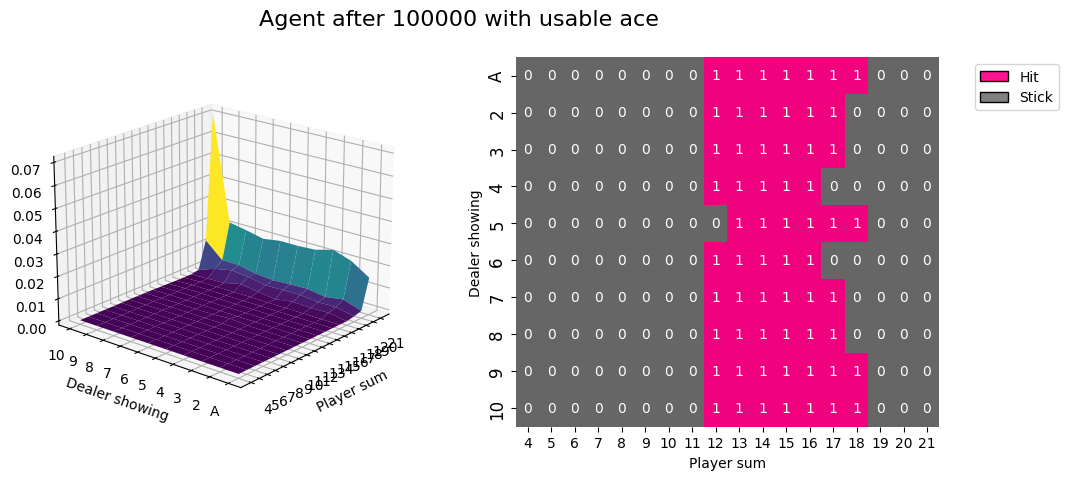

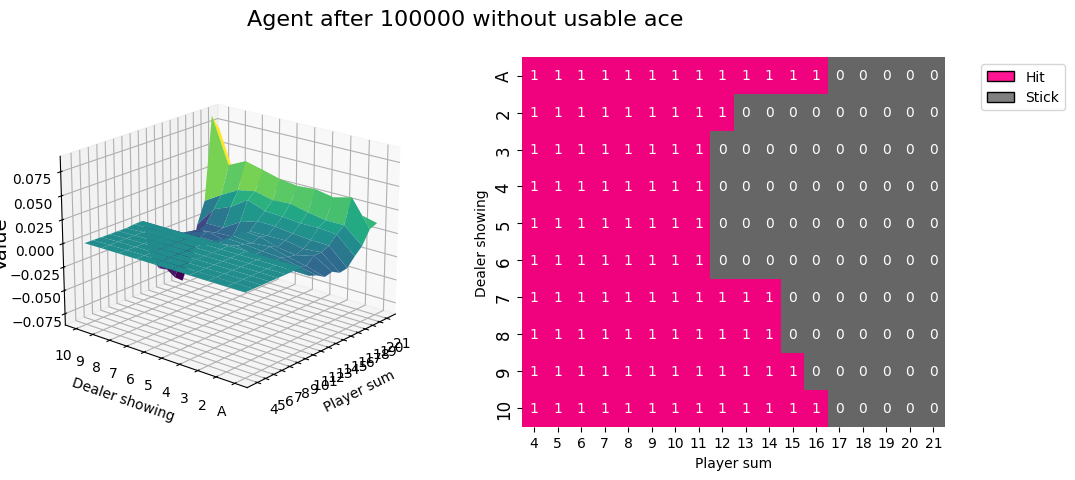

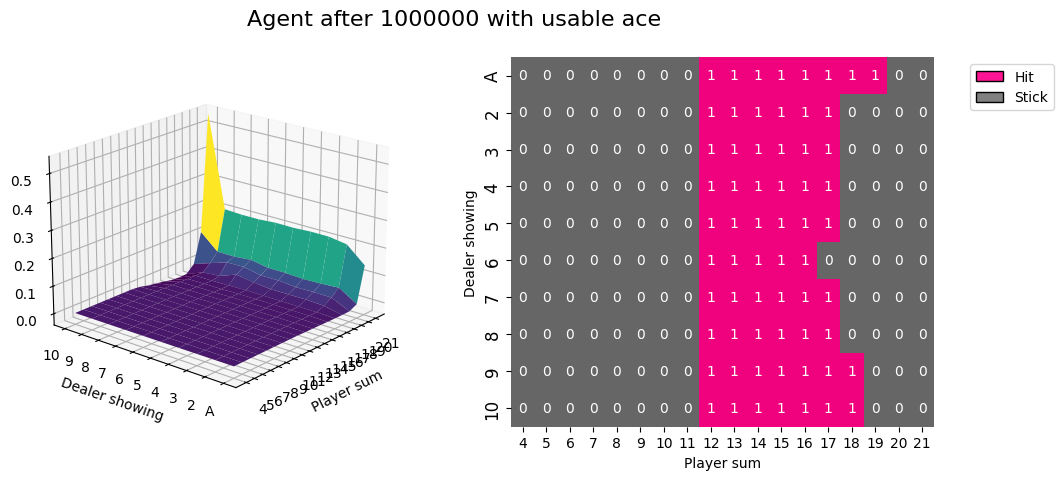

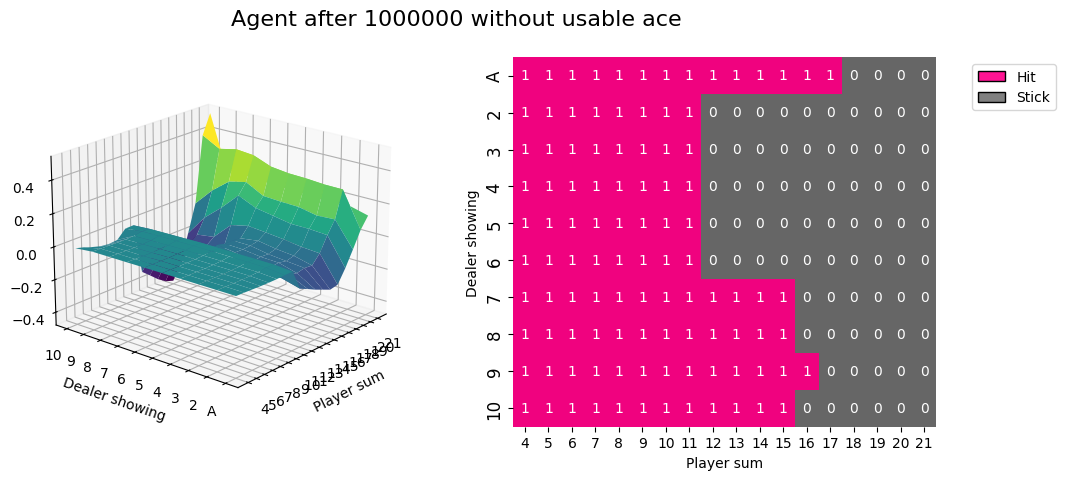

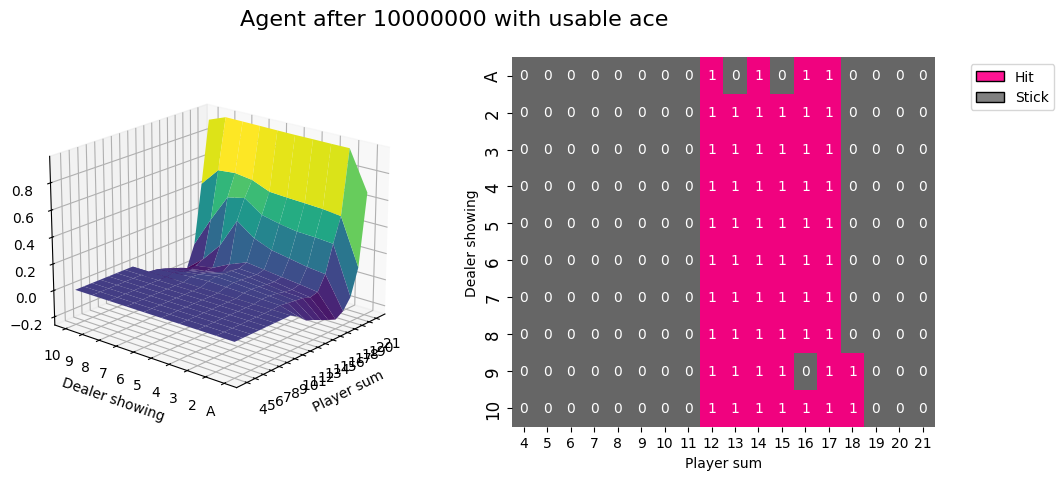

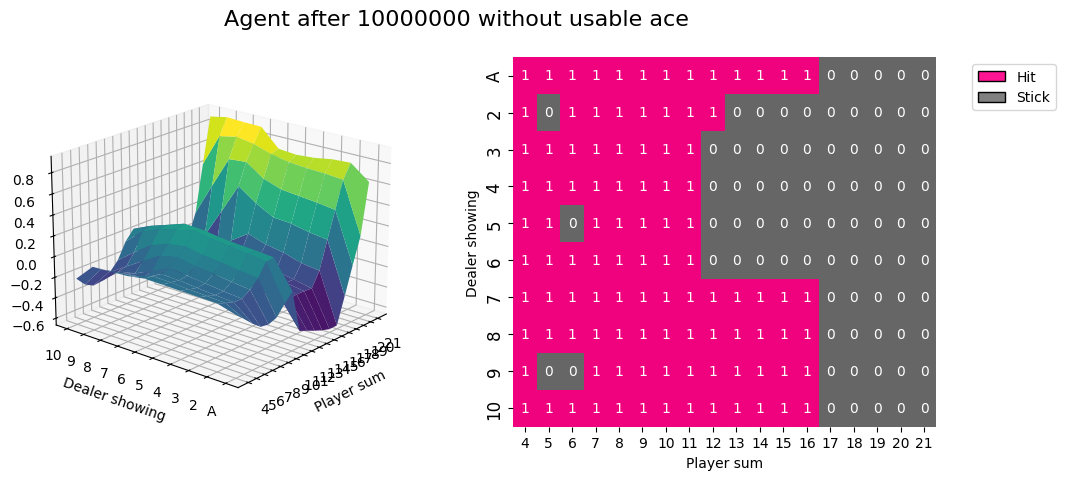

In [41]:
legend_elements = [
    Patch(facecolor="deeppink", edgecolor="black", label="Hit"),
    Patch(facecolor="grey", edgecolor="black", label="Stick"),
]

for j, i in enumerate(agent_evolution_first):
    # state values & policy with usable ace (ace counts as 11)
    value_grid, policy_grid = create_grids(i, booleans=(True,))
    fig1 = create_plots(value_grid, policy_grid, title=f"Agent after {time_stamp[j]} with usable ace", legend_elements = legend_elements)
    plt.show()
    
    # state values & policy without usable ace (ace counts as 1)
    value_grid, policy_grid = create_grids(i, booleans=(False,))
    fig2 = create_plots(value_grid, policy_grid, title=f"Agent after {time_stamp[j]} without usable ace", legend_elements = legend_elements)
    plt.show()

Then, the analysis will proceed by giving an evaluation of how the agent behaves in 3 moments of his life. Whenever the agent reaches a certain amount of episodes played, he will play a few games to see what results he gets and the state of the q_matrix will be saved.

In my case, I chose 100,000, 1,000,000 and 10,000,000 as timestamps.

All in all the agent in the first environment has no problems. The state space is "small" for now and has no problems easily exploring all possible states and developing a game strategy, a strategy that is close to the fundamental one.

1) After 100,000 episodes, the agent is still an infant, but not an innocent one. He likes to play aggressively against high dealer values, but is afraid when he has low values. In fact we can see that both with the usable ace and without the grid it presents holes in the player's low values and lines that stretch towards the sum of 21. He likes to make risky decisions but the agent is still in an exploratory phase .
2) After 1,000,000 games the agent begins to be an adult capable of choosing which move is the best. Whether with an ace or without, the grid starts to look very similar to the fundamental strategy table. The holes it presented have been filled thanks to further exploration, and now the agent will continue to make greedy decisions with just a few exceptions since the delta value that defines randomness is not equal to 0.
Furthermore, when the ace is not usable, we notice a gleaned structure in the grid, a structure that we like to see and look for. Why? Because when playing with integer values, as soon as the dealer exceeds a certain threshold, all the decisions the player can make, regardless of his value in hand, is to hope that the dealer will burst.
3) After 10,000,000 episodes, the agent has become old and is starting to be wise enough to understand that with an ace using it is better to keep an 18 or a 17 if the dealer has something dangerous. If the ace is not usable he has decided that in some cases if the sum of the hand is a low value, he prefers to see if it is the dealer who jumps. While at high values ​​it maintains that square structure we were talking about before.

Conclusion: the agent behaved very well. He managed to replicate the fundamental strategy table almost to perfection. However, it is all in all a simple environment with few states. We hope, I hope, to be able to obtain or even replicate the same results for future environments.

The agent after 100000 achieve: 4409 win, 4727 lose and 864 draw 

The agent after 1000000 achieve: 4362 win, 4773 lose and 865 draw 

The agent after 10000000 achieve: 4406 win, 4746 lose and 848 draw 



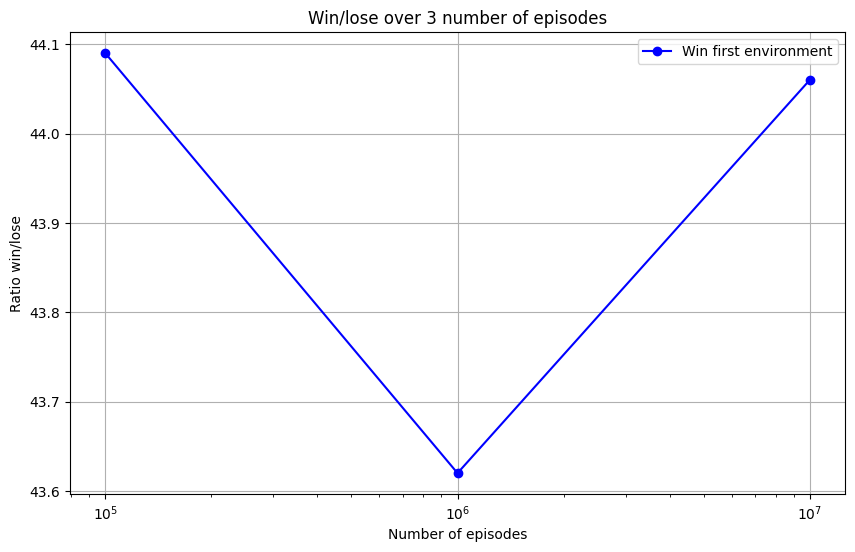

In [13]:
for i, win in enumerate(win_lose_first):
    print(f"The agent after {time_stamp[i]} achieve: {win[0]} win, {win[1]} lose and {10000-win[0]-win[1]} draw \n")

games = [100000, 1000000, 10000000]

wins_firstEnvironment = [item[0]/100 for item in win_lose_first]

plt.figure(figsize=(10, 6))
plt.plot(games, wins_firstEnvironment, label='Win first environment', marker='o', linestyle='-', color='blue')

plt.xlabel('Number of episodes')
plt.ylabel('Ratio win/lose')
plt.title('Win/lose over 3 number of episodes')
plt.legend()

plt.grid(True)
plt.xscale('log')
plt.show()

In the execution I'm evaluating right now, in the first phase the agent gets 44%, in the second it drops to 43.2% and in the third it goes back up to 43.8%. As mentioned at the beginning, since there are so many random elements that influence it is difficult to draw conclusions. This graph is intended to serve as a way to compare the various environments that will come to understand whether someone performs better or worse than the others. 

Of course, since blackjack is a negative-sum gambling game, the win percentage will always fluctuate between 42% and 45%, in the dealer's favor. So if the value tends to be too lower the agent is clearly doing something wrong, which may be due to too little exploration, incorrect decisions or a state space that is too large to explore. However, if he is too high, he has understood something that we don't know yet.

# Second environment

The second environment introduce an element of randomness:
- only 2 actions allowed (same as before)
- simple reward function (same as before)
- finite number of deck with a reshuffle after half of the deck have been drawn.

The first step towards a realistic environment has been taken.

## More support functiont for menage the new pile of decks

In [14]:
def build_deck(n_decks: int) -> list:
    """ Build a list based on the number of decks * number of different 
    sign a card can have and shuffle it.
    """
    l = deck * 4 * n_decks
    np.random.shuffle(l)
    return l

def valid_deck(l: list, n_decks: int) -> list:
    """ check if the deck is still playable or have to be rebuilt. """
    if len(l) < (n_decks * 13 * 4)/2 + np.random.randint(-15,15):
    # if half of the deck have been drawn (not half precise, so an uncertainty is added)
    # the deck must be rebuilt and shuffled
        return build_deck(n_decks)
    return l

def draw_real_card(l: list) -> list:
    """ Draw a random card from the real based deck and remove it. """
    return l.pop(0)

def draw_real_hand(l: list) -> list:
    """ Draw 2 random card from the deck and return a list of them. """
    return [l.pop(0), l.pop(0)]

## Make some change to the environment class

In [15]:
class BlackjackEnv_finiteDecks(BlackjackEnv):
 
    def __init__(self, natural: bool=False, sab: bool=False, n_decks: int=6):
        """Initialize a blackjack environment with a fixed action space and 
        observation space, the natural or S&B rules and the player's hand.
        
        Args: 
            natural: The natural blackjack rule
            sab: The Sutton and Barto blackjack rule
            n_decks: The number of deck we want in the stack
        """

        super().__init__(natural, sab)
        self.n_decks = n_decks # we set the number of decks
        self.deck = build_deck(self.n_decks) # and build the deck based on that number

    def step(self, action: int) -> (tuple[int, int, bool], float, bool):
        """ The environment evolves based on the action taken by 
        the q_agent and returns a 'screenshot' of how it has changed.

        Args: 
            action: The action that the agent choose
        """
        
        assert self.action_space.contains(action)
        if action == 1: 
            self.player.append(draw_real_card(self.deck)) # add a cart to the player's hand from the real deck
            
            if is_bust(self.player):
                terminated = True 
                reward = -1.0 
            else:
                terminated = False
                reward = 0.0
        
        elif action == 0: 
            
            terminated = True
            while sum_hand(self.dealer) < 17: 
                self.dealer.append(draw_real_card(self.deck)) # we now draw from the real deck
            reward = cmp(score(self.player), score(self.dealer))
            
            if (
              self.sab 
              and is_natural(self.player) 
              and not is_natural(self.dealer)
            ): 
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                reward = 1.5

        return self._get_obs(), reward, terminated

    def _get_obs(self) -> tuple[int, int, bool]:
        """ Prapare the observation for the q_agent with the player hand, 
        dealer face up card and a flag for usable ace. 
        """
        return super()._get_obs()

    def reset(self) -> (tuple[int, int, bool], dict):
        """ Reset the episode checking if the deck have to be reshuffled, 
        drawi the hands of player and dealer, and then return the state 
        of the game. 
        """
        # first we check if the deck is valid, if not we shuffle all the cards, otherwise we play
        self.deck = valid_deck(self.deck, self.n_decks) 
        self.dealer = draw_real_hand(self.deck)
        self.player = draw_real_hand(self.deck)

        return self._get_obs()

## Train the second environment

In [16]:
# hyperparameters

learning_rate = 0.0001
n_episodes = 10_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.01

In [17]:
env = BlackjackEnv_finiteDecks(natural=True, sab=True)

agent = BlackjackAgent(
    action_space=env.action_space.n,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [18]:
agent_evolution_second, win_lose_second = train(env, agent, time_stamp, n_episodes)

100%|████████████████████████████| 10000000/10000000 [02:58<00:00, 56057.89it/s]


## Plot the result

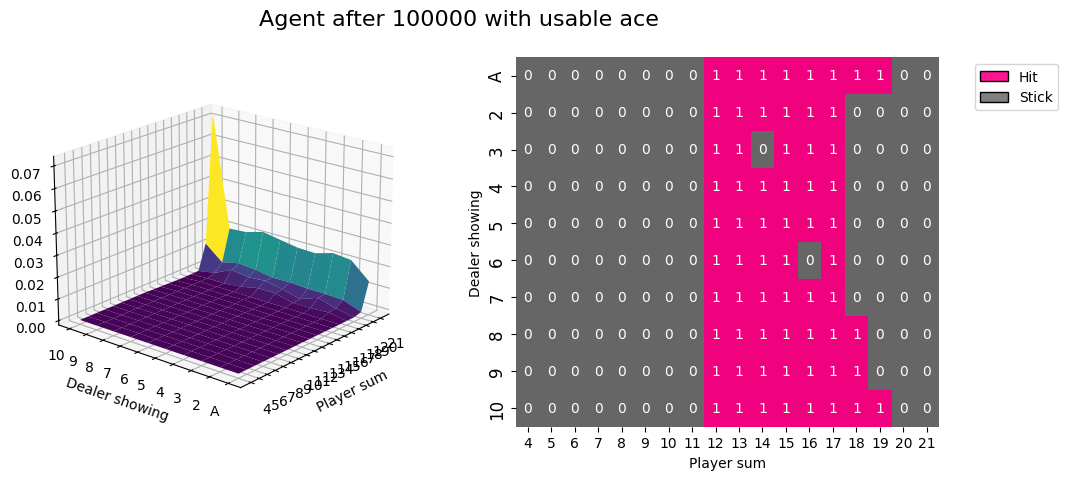

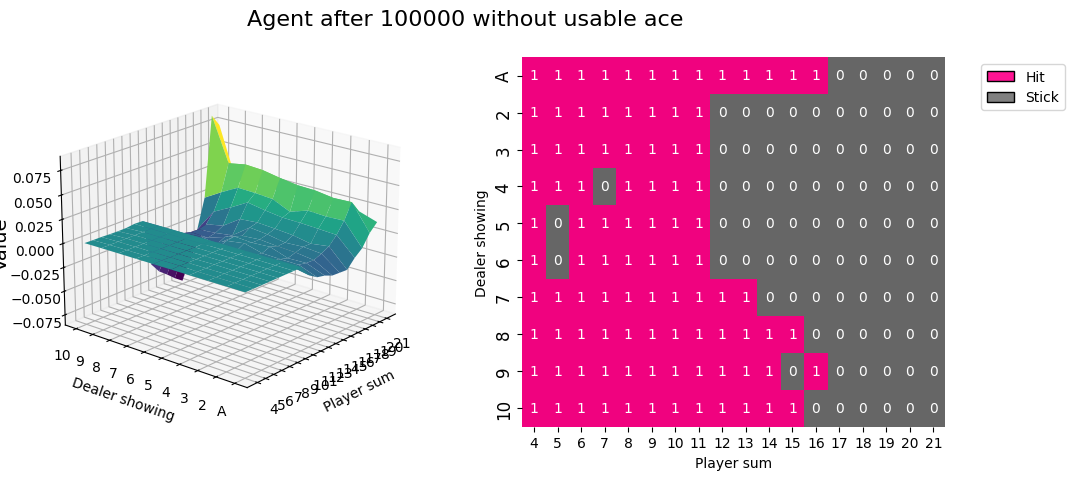

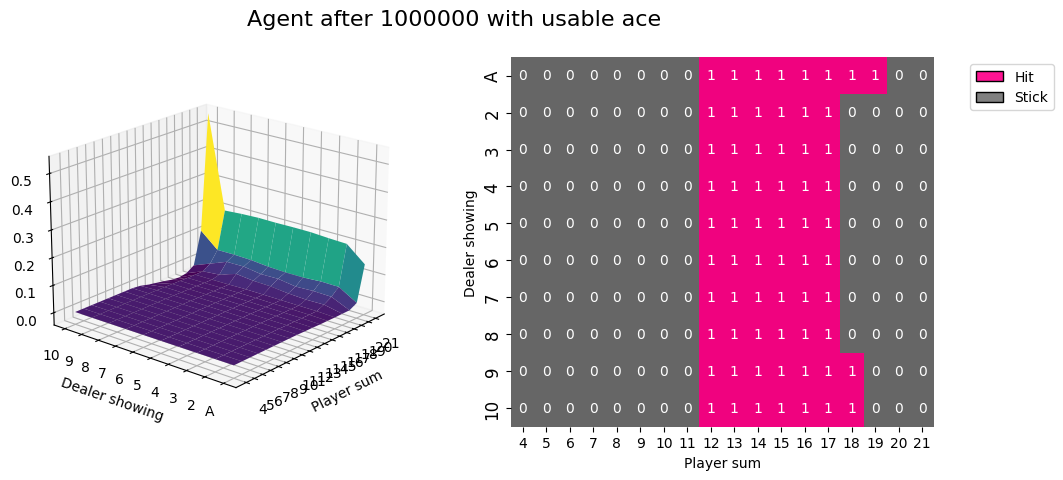

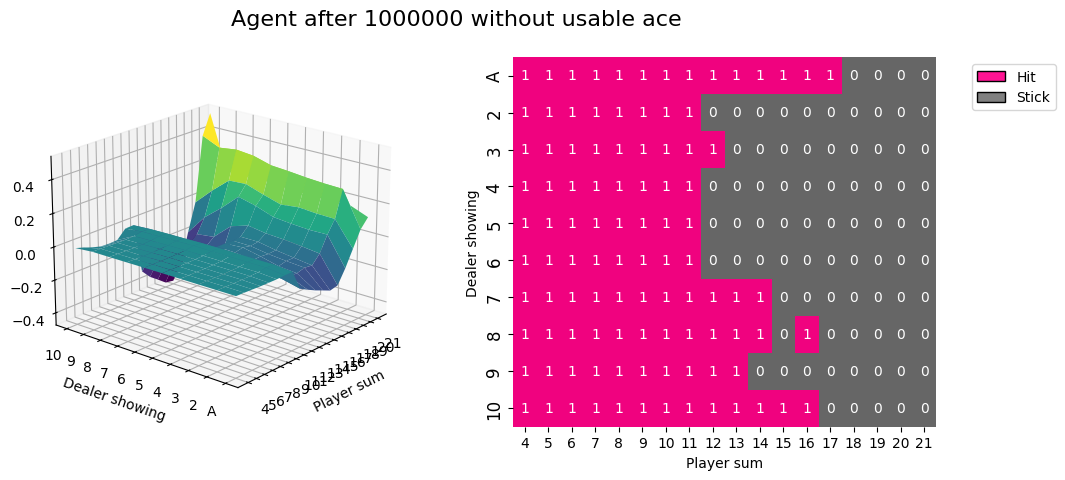

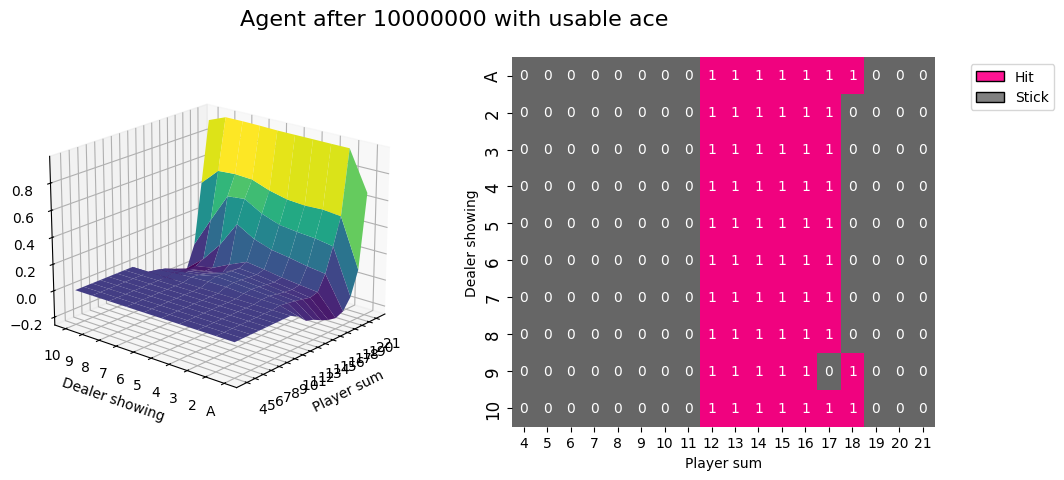

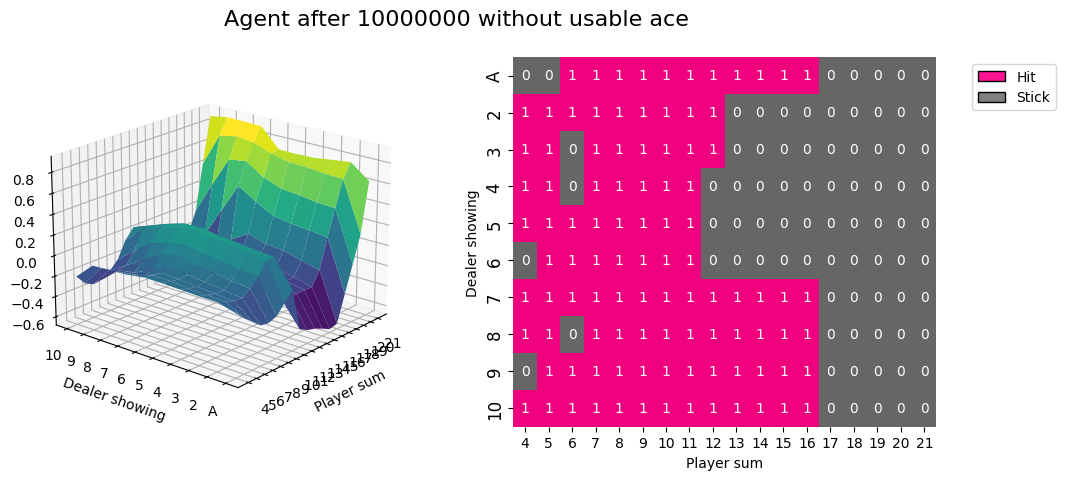

In [19]:
legend_elements = [
    Patch(facecolor="deeppink", edgecolor="black", label="Hit"),
    Patch(facecolor="grey", edgecolor="black", label="Stick"),
]

for j, i in enumerate(agent_evolution_second):
    # state values & policy with usable ace (ace counts as 11)
    value_grid, policy_grid = create_grids(i, booleans=(True,))
    fig1 = create_plots(value_grid, policy_grid, title=f"Agent after {time_stamp[j]} with usable ace", legend_elements = legend_elements)
    plt.show()
    
    # state values & policy without usable ace (ace counts as 1)
    value_grid, policy_grid = create_grids(i, booleans=(False,))
    fig2 = create_plots(value_grid, policy_grid, title=f"Agent after {time_stamp[j]} without usable ace", legend_elements = legend_elements)
    plt.show()

With the second environment, a change was made to the probability distribution that generates the value of cards. From this point on, hands are no longer independent variables, but become draws without insertion. I will not go into details because it is not inherent in this notebook. 
BUT, since the basic strategy does not take into account how many cards are inside the deck but only the cards that are seen (that is why it is called basic), the results we get should not vary too much from those in the first environment. I expect, however, that the agent will be able to explore the space of states better, since as cards come out there is a greater probability that different events will happen. 

If, on the other hand, we wanted to make the deck a key component for the agent to exploit, then we are doing what is called card counting in the blackjack world. But since this analysis stops only at repricing the fundamental strategy, I will not go any further. Perhaps in a future evolution of the project.

Resuming the analysis, the value grid on the left is identical to that in the first environment while the policy grid is slightly different, in a better way. In fact, as I mentioned in the lines above, the change to the deck brought stability to the agent. 
1) After 100,000 episodes, it has fewer holes here and also the lines that indicated an aggressive tendency are less frequent. This sets the stage for good results.
2) After 1,000,000 episodes, as hoped by the first phase, the agent presents great results in the grid, both with usable and non-usable ace. Comparing with the fundamental strategy table, so far it is the one that has come as close as possible. But we are only at the beginning.
3) After 10,000,000 episodes, as in the first environment he has secrets he won't tell us. If at high values he maintains a very good strategy, at low values he would rather see the dealer jump than play the hand.

Paying more attention to the value grid, we can see a clear evolution over time. In the case of a usable ace, between 100,000 episodes 1 the 1,000,000 does not seem to change much, since the shape is the same. It actually went from having at peak 0.07 to being able to achieve a 0.5 gain. It then arrives after 10,000,000 to take on a nice wave that becomes negative when the dealer has high casts. We now observe if the ace is not usable, there is a slow evolution from a plane ranging between -0.01 and 0.01 to the formation of a wave and then reaching a saddle after 10,000,000 episodes. With excellent peaks reaching as high as 0.9 in some cases but still achieving negative values around -0.6. These values are more or less objective, but they tend to maintain this average after 10,000,000 matches. 

Conclusion: the agent has achieved an improvement over the first environment and, as repeated many times before, the deck has brought stability. In the next environment, the space of states will increase, and I will expect a deterioration. I think for now this will be the agent that will have come closest to the fundamental strategy.

The agent after 100000 achieve: 4336 win, 4822 lose and 842 draw 

The agent after 1000000 achieve: 4292 win, 4837 lose and 871 draw 

The agent after 10000000 achieve: 4284 win, 4791 lose and 925 draw 



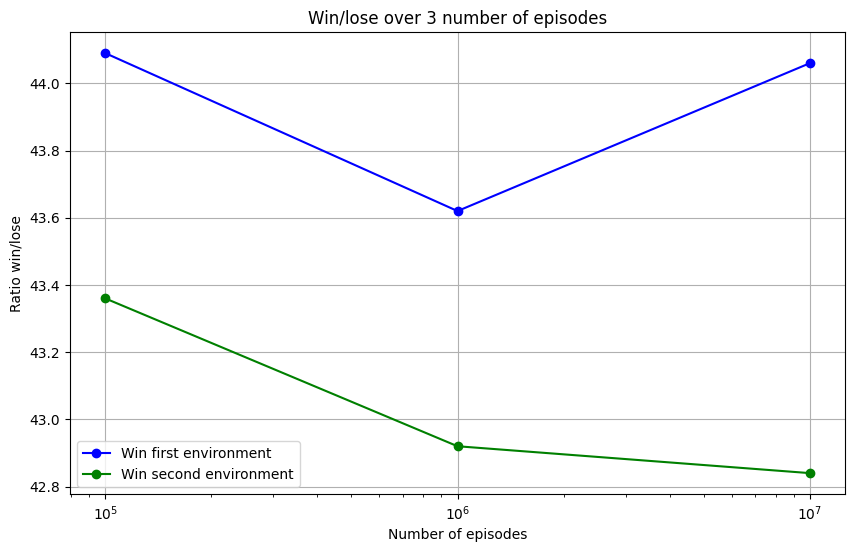

In [61]:
for i, win in enumerate(win_lose_second):
    print(f"The agent after {time_stamp[i]} achieve: {win[0]} win, {win[1]} lose and {10000-win[0]-win[1]} draw \n")

wins_secondEnvironment = [item[0]/100 for item in win_lose_second]

plt.figure(figsize=(10, 6))
plt.plot(games, wins_firstEnvironment, label='Win first environment', marker='o', linestyle='-', color='blue')
plt.plot(games, wins_secondEnvironment, label='Win second environment', marker='o', linestyle='-', color='green')


plt.xlabel('Number of episodes')
plt.ylabel('Ratio win/lose')
plt.title('Win/lose over 3 number of episodes')
plt.legend()

plt.grid(True)
plt.xscale('log')
plt.show()

The second agent should be able to have less variability among the 3 winrates and actually stay around 43%-44% win ratio. Thus, this graph has become a way to have an index of how well the agent is doing that will be compared with the others.

# Third environment

The third environment introduce a new action:
- 3 actions allowed: stick, draw and split
- simple reward function (same as before)
- finite number of deck with a reshuffle after half of the deck have been drawn (same as before).

The action space have expanded and so the q_table, let's see how the agent will deal with the split.

From now on, all code becomes complicated. This is due to having to isolate what the agent can see and interact with, compared to what the environment must manage and carry forward. In the code you will find more information and details.

## As the first two environments, we introduce two methods for menage the split

In [21]:
def split(hand: list, i: int) -> None:
    """ If the player decide to split a pair of card we have to work with a list of list for deal with the multiple hands.
    But, if the already separated hand get a pair again, it could be split once more. """
    hand.append([hand[i].pop()])

def is_split(hand: list) -> int:
    """ CHeck for a possible split in one hand. """
    if len(hand) != 2: # the split is possible only if it's the first action of the hand ergo the player have only 2 cards
        return 0
    return 1 if hand[0] == hand[1] else 0 # and, if the player have 2 cards and their the same

## Make some change to the environment class

In [22]:
class BlackjackEnv_split(BlackjackEnv_finiteDecks):
 
    def __init__(self, natural: bool=False, sab: bool=False, n_decks: int=6, split_reward: float=0):
        """Initialize a blackjack environment with a fixed action space and 
        observation space, the natural or S&B rules and the player's hand.
        
        Args: 
            natural: The natural blackjack rule
            sab: The Sutton and Barto blackjack rule
            n_decks: The number of deck we want in the stack
            split_reward: The reward that the q_agent will get for splitting
        """
        
        self.action_space = spaces.Discrete(3)  # we add another actiom so the space expand
        self.observation_space = spaces.Tuple((spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(2))
        )  # the observation space expand too, we want a 0/1 value for keep track if the split is possible

        self.natural = natural
        self.sab = sab

        self.n_decks = n_decks
        self.deck = build_deck(self.n_decks)

        self.split_reward = split_reward # we set a reward for choosing the split, if not the agent have to use the split for future reward
        self.player = [[]] # the environment now have to keep trace of more hands, not just one
    
    def step(self, action: int, current_hand: int) -> (tuple[int, int, bool, bool], float, bool):
        """ The environment evolves based on the action taken by 
        the q_agent and returns a 'screenshot' of how it has changed.

        Args: 
            action: The action that the agent choose
            current_hand: The hand the enviroment have to take action on
        """
        # Now, To handle the possibility of having multiple hands in play at the same time, 
        # I need to make sure that the agent and the environment are in sync. 
        # To do this, I use a counter that the agent will pass to the environment to tell it 
        # which hand it should perform a certain action on.
        
        assert self.action_space.contains(action) 
        if action == 1:
            self.player[current_hand].append(draw_real_card(self.deck))
            
            if is_bust(self.player[current_hand]):
                terminated = True 
                reward = -1.0 
            else:
                terminated = False
                reward = 0.0
        
        elif action == 0:
            
            terminated = True
            while sum_hand(self.dealer) < 17: 
                self.dealer.append(draw_real_card(self.deck))
            reward = cmp(score(self.player[current_hand]), score(self.dealer))
            
            if (
              self.sab 
              and is_natural(self.player[current_hand]) 
              and not is_natural(self.dealer)
            ): 
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player[current_hand])
                and reward == 1.0
            ):
                reward = 1.5
                
        else: # split: divide the hand and add a card to each one
            split(self.player, current_hand) # we divide the two identical card appending one to the hand of the player list
            self.player[current_hand].append(draw_real_card(self.deck)) # then, we give a new card to the current hand and the new hand
            self.player[-1].append(draw_real_card(self.deck))
            terminated = False
            reward = self.split_reward # 0 if we want that the split does not provide a reward, 
                                       # or incrase the value to 0.1-0.2 to incentivize it

        return self.get_obs(current_hand), reward, terminated # this time the bos have another value: if the split is allowed

    def get_obs(self, current_hand: int) -> tuple[int, int, bool, bool]:
        """ Prapare the observation for the q_agent with the player hand, 
        dealer face up card and a flag for usable ace. 

        Args:
            current_hand: The value of the hand the enviroment is working on
        """
        return (sum_hand(self.player[current_hand]), 
                self.dealer[0], 
                usable_ace(self.player[current_hand]), 
                is_split(self.player[current_hand]))

    def reset(self) -> (tuple[int, int, bool, bool], dict):
        """ Reset the episode checking if the deck have to be reshuffled, 
        drawi the hands of player and dealer, and then return the state 
        of the game. 
        """
        self.deck = valid_deck(self.deck, self.n_decks)
        self.dealer = draw_real_hand(self.deck)
        self.player = [[]]
        self.player[0] = draw_real_hand(self.deck)

        return self.get_obs(0)

## Make some change to the agent class

In [23]:
class BlackjackAgent_split(BlackjackAgent):
    
    def __init__(self, 
                 action_space: int, 
                 learning_rate: float, 
                 initial_epsilon: float, 
                 epsilon_decay: float, 
                 final_epsilon: float, 
                 discount_factor: float = 0.95, 
                 unallowed_split: float=0.01):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
            unallowed_split: The negative value given if split is chosen when not allowed
        """
        super().__init__(action_space, 
                         learning_rate, 
                         initial_epsilon, 
                         epsilon_decay, 
                         final_epsilon, 
                         discount_factor
        )

        self.unallowed_split = unallowed_split

    def get_action(self, obs: tuple[int, int, bool, bool], random: bool=True) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.

        Args:
            obs: What the agent see of the enviroment
            random: If set to False, the agent no longer behaves randomly
        """
        if np.random.random() < self.epsilon and random:
            if obs[3]: # if the split is allowed, we make the agent take one of 3 possible actions
                return np.random.randint(3)
            return np.random.randint(2) # if not, just 2 possible actions

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            if obs[3]: # if the split is allowed, we choose the action with the higher value
                return self.q_values[obs].argmax()
            action = self.q_values[obs][:2].argmax() # otherwise, we have to chose the action with higher valure between stick or draw
            if self.q_values[obs].argmax() == 2: #if the q_agent would have choose split even if the split was not allowed, we give a little negative reward
                self.q_values[obs][2] -= self.unallowed_split
            return action

    def update(self, 
               obs: tuple[int, int, bool, bool], 
               action: int, 
               reward: float, 
               terminated: bool, 
               next_obs: tuple[int, int, bool, bool],
    ) -> None:
        """Updates the Q-value of an action.
        
        Args: 
            obs: What the agent see of the enviroment before take an action
            action: The action taken by the agent
            reward: The reward given after taking an action on the observation
            terminated: If the enviroment has terminated
            next_obs: How the enviroment evolved after the action has been taken
        """
        super().update(obs, 
                       action, 
                       reward, 
                       terminated, 
                       next_obs
        )

    def decay_epsilon(self) -> None:
        super().decay_epsilon()

## Make some change to the play and train method

In [24]:
def play_some_game_split(env, agent) -> str:
    """ Make the agent play some hands step by step and then 
    run 10 000 games to check the agent's win rates in the current state.
        
    Args:
        env: The blackjack environment
        agent: The q_value agent
    """
    # decomment for watch some game played by the agent in the 3 phase
    # action_to_string = {0 : "stay", 1 : "hit", 2 : "split"}
    # print(f"Let's play some hands... ")
    # for i in range(10):
    #     i = 10
    #     break
    #     print(f"Game number {i+1}, the dealer is giving the card...")
    #     sleep(2)
    #     obs = env.reset()
    #     print(f"The player hold {env.player} while the dealer show a {env.dealer[0]}")
    #     done = [False]
    #     n_hand = 1 
    #     current_hand = 0 
    #     while current_hand < n_hand:
    #         while not done[current_hand]: 
    #             action = agent.get_action(obs, random = False)            
    #             print(f"The player choose to {action_to_string[action]}...")
    #             sleep(1)
    #             print(f"The dealer is taking care...")
    #             sleep(2)
    #             next_obs, reward, terminated = env.step(action, current_hand) 
                
    #             if terminated: 
    #                 print(f"The hand dealer is {env.dealer}, so the game endend with a reward of: {reward}")
    #                 sleep(2)
    #             else: 
    #                 print(f"The player hold {env.player} while the dealer show a {env.dealer[0]}")
    #                 sleep(2)
                
    #             done[current_hand] = terminated
    #             if n_hand != 1 and current_hand+1 != n_hand and terminated:
    #                 obs = env.get_obs(current_hand+1) # change the next obs to the current
    #             else:
    #                 obs = next_obs
                
    #             if action == 2:
    #                 n_hand += 1
    #                 done.append(False)
    #         current_hand += 1
    # decomment for read the print output before resetting them
    #sleep(10)
    #clear_output(wait=True)

    win_lose = [0, 0]
    for i in range(10_000):
        obs = env.reset()
        done = [False]
        n_hand = 1 
        current_hand = 0 
        while current_hand < n_hand:
            while not done[current_hand]: 
                action = agent.get_action(obs, random = False)            
                next_obs, reward, terminated = env.step(action, current_hand)                     

                done[current_hand] = terminated
                if n_hand != 1 and current_hand+1 != n_hand and terminated:
                    obs = env.get_obs(current_hand+1)
                else:
                    obs = next_obs
                
                if action == 2:
                    n_hand += 1
                    done.append(False)
                    
            current_hand += 1

        if reward > 0.0:
            win_lose[0] += 1
        elif reward < 0.0:
            win_lose[1] += 1
                
    return win_lose

In [25]:
def train_split(env, agent, time_stamp:list[int], n_episodes=1_000_000) -> list:
    """ Train the q_value agent in and environment for some througt some number of episodes.
        
        Args:
            env: The blackjack environment
            agent: The q_value agent
            n_episodes: The number of episode that the agent have to train on
    """

    agent_evolution = []
    win_lose = []
    
    for episode in tqdm(range(n_episodes)):
        obs = env.reset()
        done = [False]  # a list of boolean for menage multiple hands if the split happen. 
                        # False = still need to be played (sum of hand <= 21 or he hasn't chosen to stick yet)
                        # True = otherwise

        n_hand = 1 # count for keep track of the number of hands in the environment
        current_hand = 0 # the hand we are playing now

        while current_hand < n_hand:
            while not done[current_hand]: # execute until all the hand are done 
                action = agent.get_action(obs)

                next_obs, reward, terminated = env.step(action, current_hand) 
    
                agent.update(obs, action, reward, terminated, next_obs)
    
                # some other lines based on the result of the action 
                done[current_hand] = terminated # set the status of the i-th hand
                # if we have terminated the execution with this hand, we go to the next one
                if n_hand != 1 and current_hand+1 != n_hand and terminated: 
                    obs = env.get_obs(current_hand+1) # change the next obs to the current
                else:
                    obs = next_obs

                # if we have taken split as action, we increse the number of hand in play and add a status of that hand to the done list
                if action == 2:
                    n_hand += 1
                    done.append(False)
            
            current_hand += 1 # if the current hand is terminated, we go to the next hand
        
        agent.decay_epsilon()

        if episode+1 in time_stamp:
            agent_evolution.append(deepcopy(agent.q_values)) 
            win_lose.append(play_some_game_split(env, agent))
            
    return agent_evolution, win_lose

## Train the third environment

In [26]:
# hyperparameters

learning_rate = 0.0001
n_episodes = 10_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.01
unallowed_split = 1

In [27]:
env = BlackjackEnv_split(natural=True, sab=True)

agent = BlackjackAgent_split(
    action_space=env.action_space.n,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    unallowed_split=unallowed_split
)

In [28]:
agent_evolution_third, win_lose_third = train_split(env, agent, time_stamp, n_episodes)

100%|████████████████████████████| 10000000/10000000 [03:25<00:00, 48666.76it/s]


## Plot the result

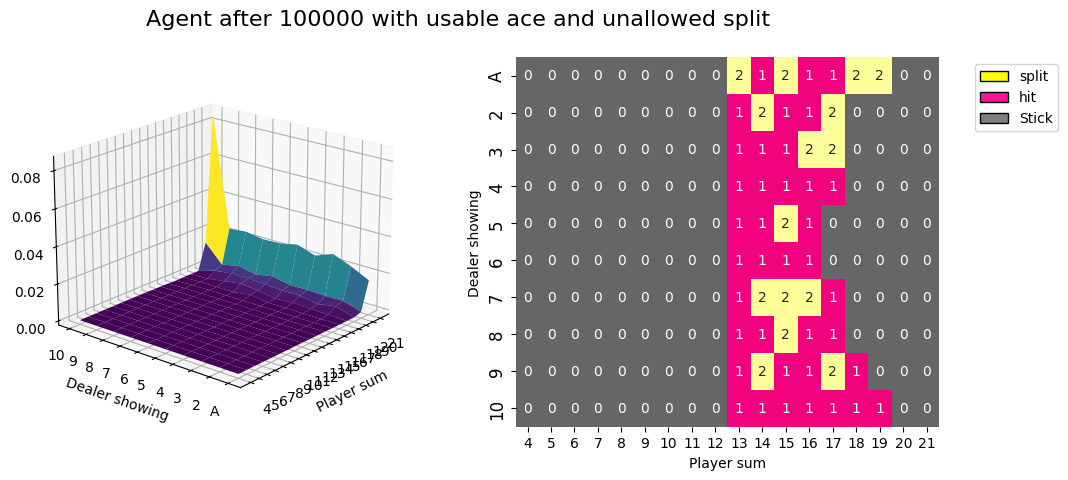

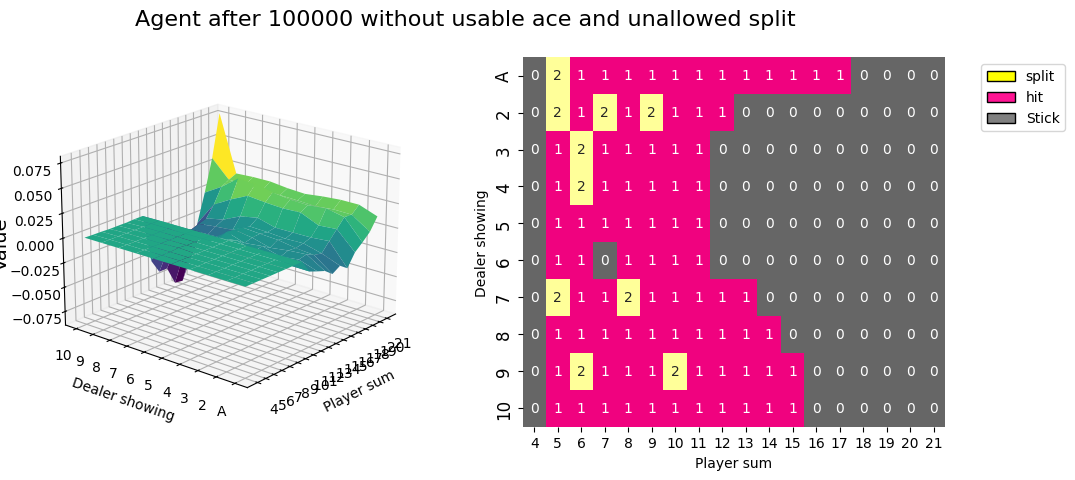

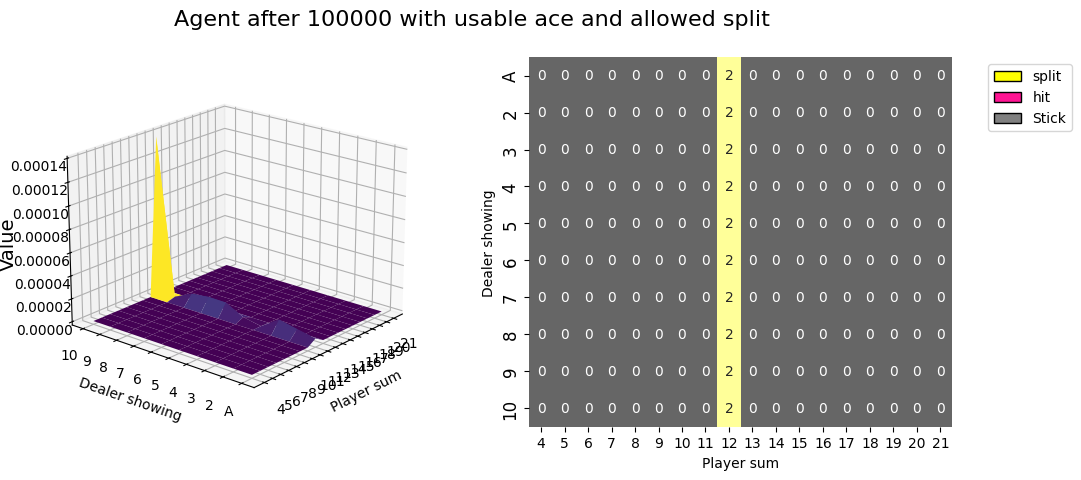

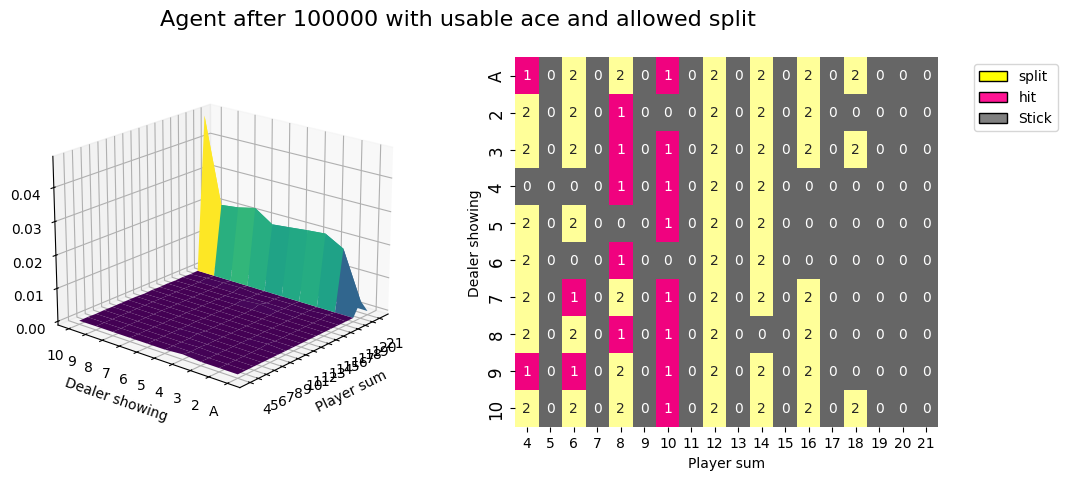

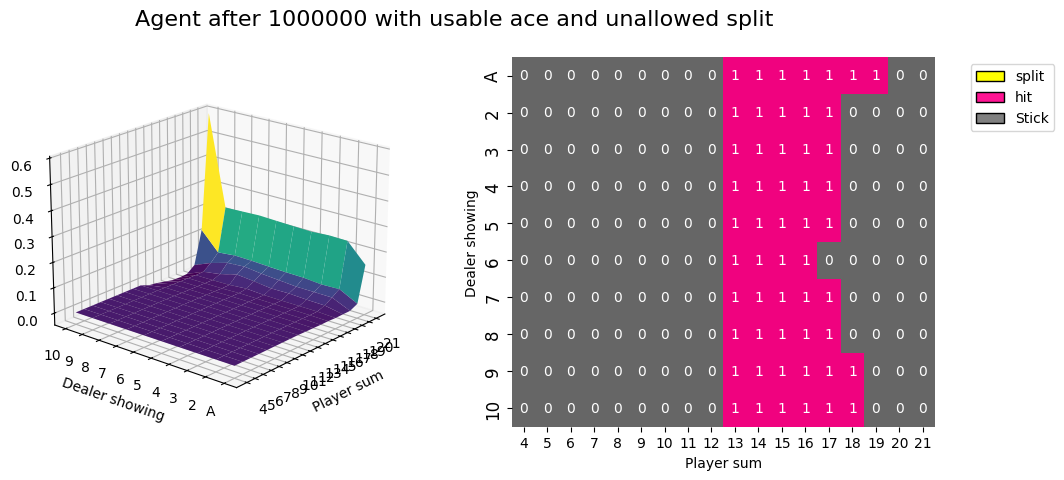

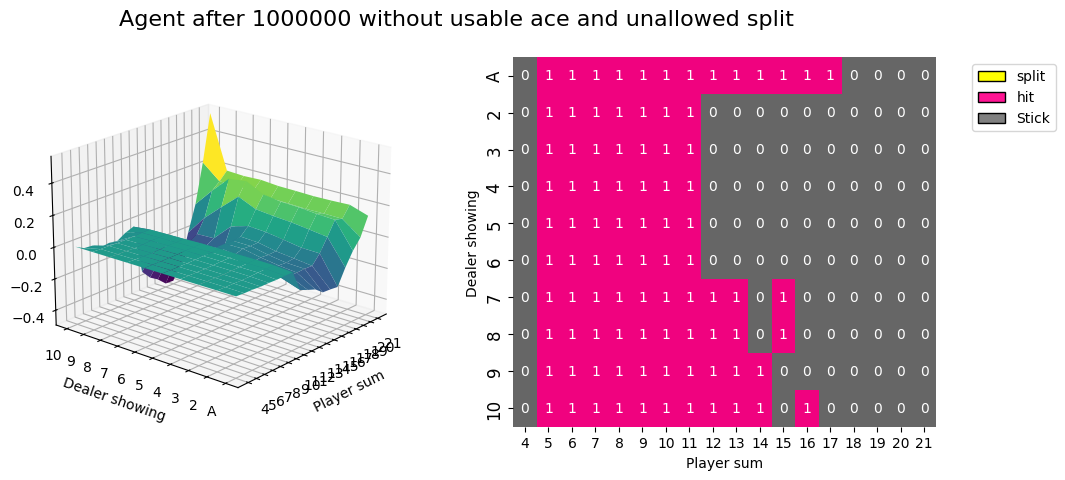

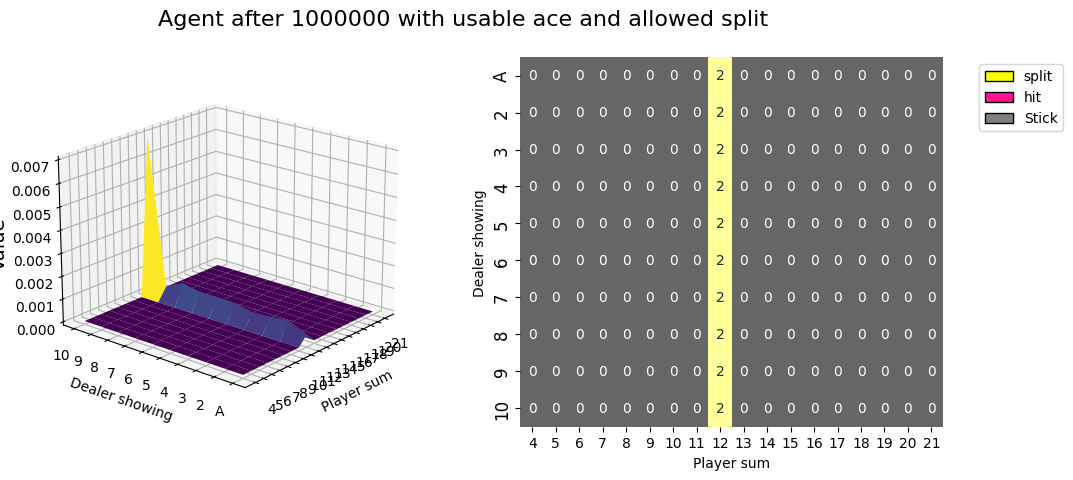

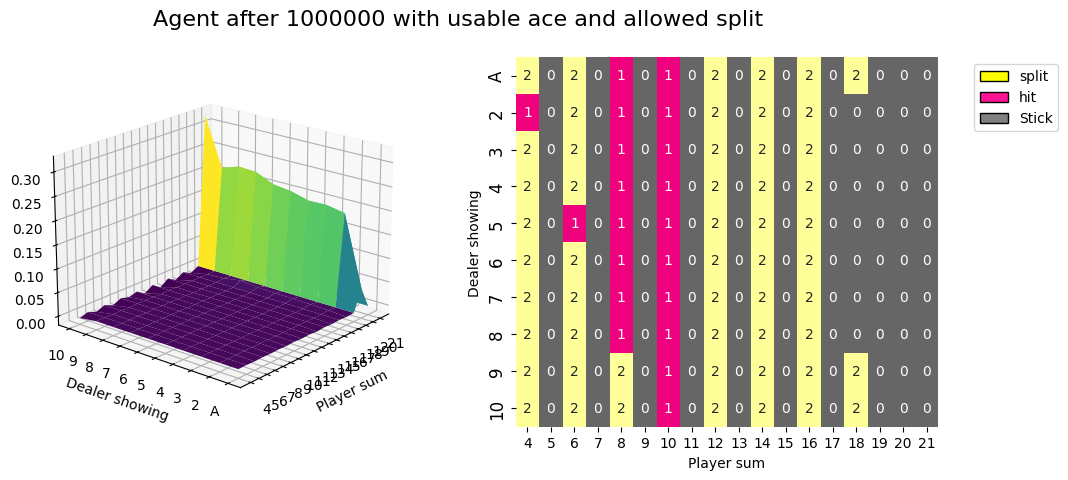

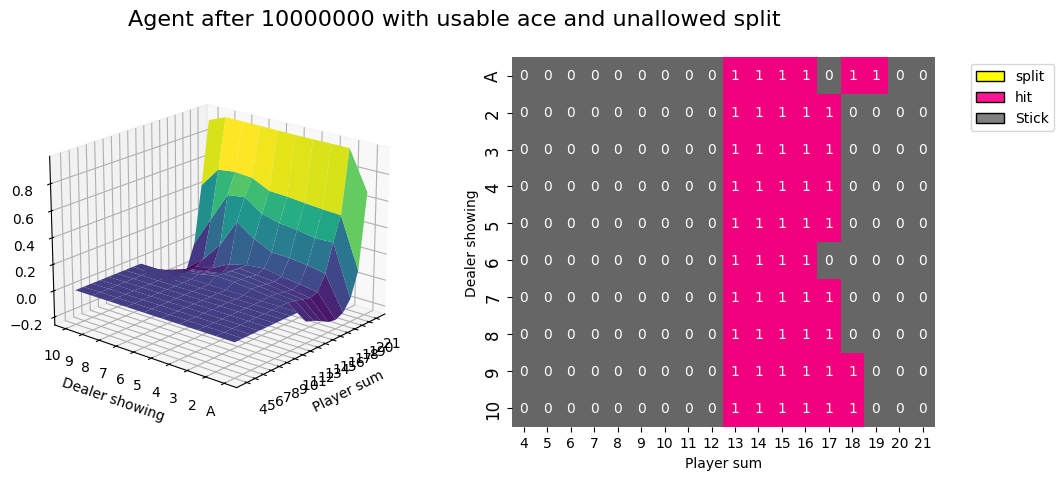

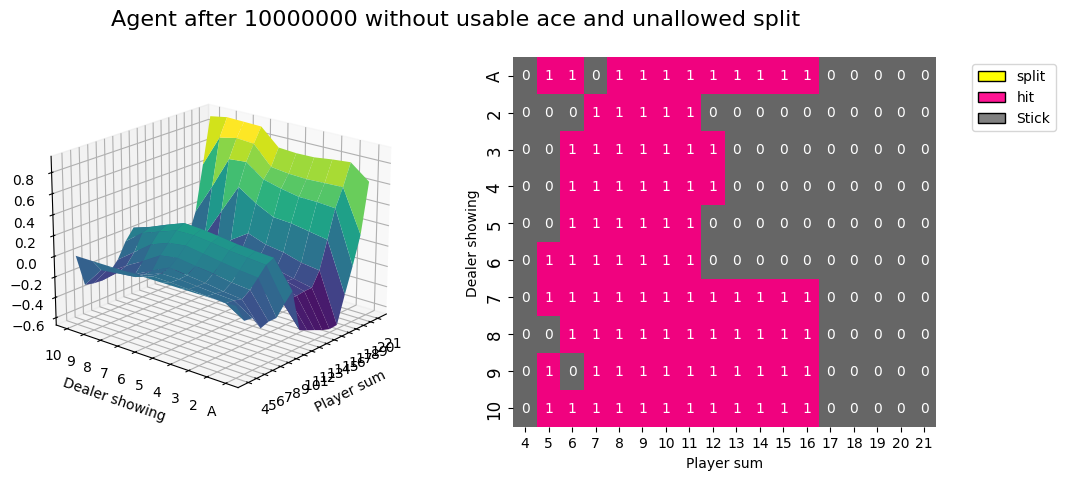

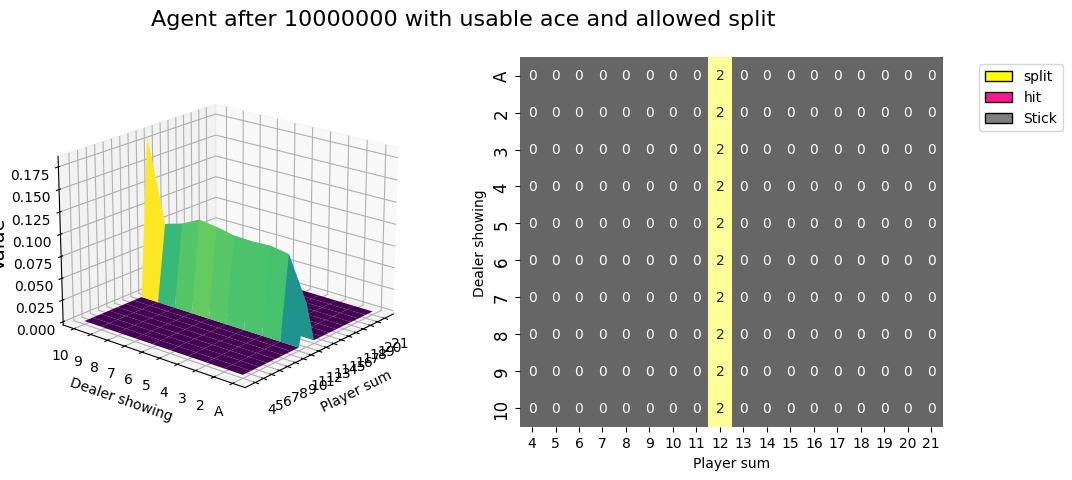

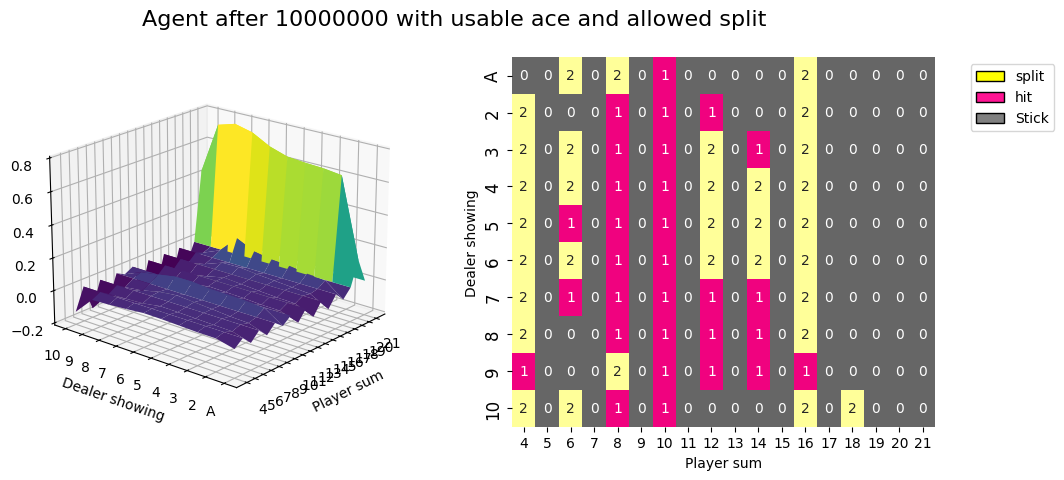

In [29]:
legend_elements = [
    Patch(facecolor="yellow", edgecolor="black", label="split"),
    Patch(facecolor="deeppink", edgecolor="black", label="hit"),
    Patch(facecolor="grey", edgecolor="black", label="Stick"),
]

for j, i in enumerate(agent_evolution_third):
    # state values & policy with usable ace (ace counts as 11)
    value_grid, policy_grid = create_grids(i, booleans=(True,False))
    fig1 = create_plots(value_grid, 
                        policy_grid, 
                        title=f"Agent after {time_stamp[j]} with usable ace and unallowed split", 
                        legend_elements = legend_elements)
    plt.show()
    
    # state values & policy without usable ace (ace counts as 1)
    value_grid, policy_grid = create_grids(i, booleans=(False,False))
    fig2 = create_plots(value_grid, 
                        policy_grid, 
                        title=f"Agent after {time_stamp[j]} without usable ace and unallowed split", 
                        legend_elements = legend_elements)
    plt.show()
    
    # state values & policy with usable ace (ace counts as 11) and split
    value_grid, policy_grid = create_grids(i, booleans=(True,True))
    fig1 = create_plots(value_grid, 
                        policy_grid, 
                        title=f"Agent after {time_stamp[j]} with usable ace and allowed split", 
                        legend_elements = legend_elements)
    plt.show()
    
    # state values & policy without usable ace (ace counts as 1) and split
    value_grid, policy_grid = create_grids(i, booleans=(False, True))
    fig1 = create_plots(value_grid, 
                        policy_grid, 
                        title=f"Agent after {time_stamp[j]} with usable ace and allowed split", 
                        legend_elements = legend_elements)
    plt.show()


Introducing an action that is only allowed under a certain condition messed up the agent. Who, rightly, not knowing the rules, chooses the action with the highest value. And, after experiencing the thrill of winning 2 hands with a split, the only thing the agent understands is the double reward. To avoid this, when the agent would like to take the split when it cannot, it receives a negative value. There are 2 ways, have it done by the environment giving a negative reward or do it manually when the agent takes an action. I chose the second, an excellent practice to see if it makes a different change is to try the first.

Anyway, going back to the agent's behavior:

1) After 100,000 episodes, the newborn still has to figure out what he can and cannot do. The fact that 2 equal values are needed to perform the split means that it rarely happens, so the agent needs a few more tries before settling on the right policy. However, if we evaluate the splits as hits, the agent is performing as well as the one in the second environment. However, when he is allowed to split, he always splits the aces because they allow him to make 21 in 2 different hands and even earn 3 reward points; if the ace is not usable he divides almost randomly and does not seem to understand what he is really doing.
2) After 1,000,000 episodes, the split has disappeared when it is not allowed and the agent behaves as well as in the second environment, except for some values. However, it's fine for us because we know it depends on the randomness of the environment. while if the split is available it continues to split all the aces, even if it has very little positive reward, barely 0.001; if he has no aces available he has conceived the power of the split but no longer does it randomly.In fact, start taking the actions that are recommended by the basic strategy. He does not recommend splitting 10s and 9s, not always, and prefers to play low hands.
3) After 10,000,000 episodes, the agent resumes those elderly decisions that seem random. If the split is not available, nothing seems to have changed except a greater inclination to keep your hands low. As for splits, he's back to making what appear to be random decisions. Maybe this old man has reached his limit and the large amount of states is confusing him.

Conclusions: the agent seems to have understood how to use the split but in the long run it almost seems like a double-edged sword. He uses it a few times but those times he uses it he still manages to obtain positive results. Recall that the state of the phases has changed to a (sum of all hands)*(dealer's face-up cards)*(ace usable or not)*(split available or not). So with a boolean it has doubled the available states and needs more episodes to adapt. At the same time, however, if many episodes are made the agent begins to get confused and seems to no longer be able to manage the split, or perhaps in reality he just wants to take it easy. The value grids maintain the shape of the first environments and the split does not seem to be able to have such high values.

The agent after 100000 achieve: 4389 win, 4804 lose and 807 draw 

The agent after 1000000 achieve: 4342 win, 4770 lose and 888 draw 

The agent after 10000000 achieve: 4274 win, 4818 lose and 908 draw 



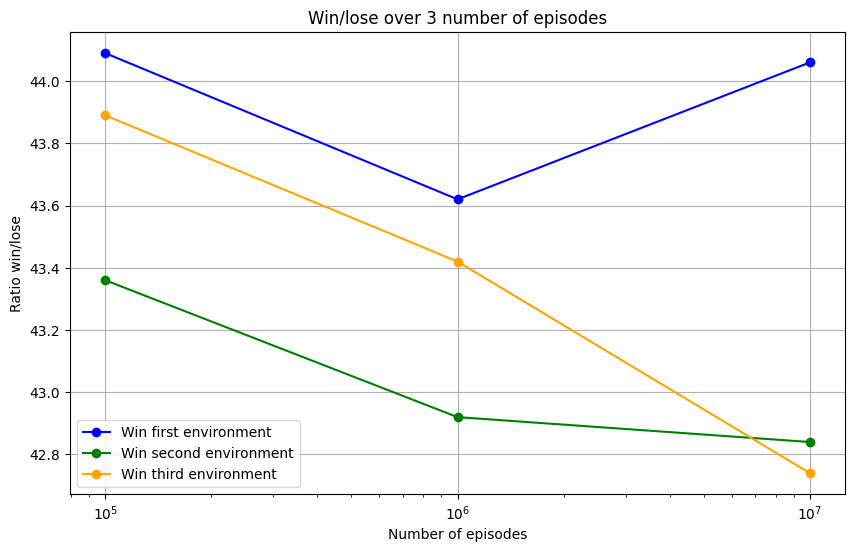

In [60]:
for i, win in enumerate(win_lose_third):
    print(f"The agent after {time_stamp[i]} achieve: {win[0]} win, {win[1]} lose and {10000-win[0]-win[1]} draw \n")

wins_thirdEnvironment = [item[0]/100 for item in win_lose_third]

plt.figure(figsize=(10, 6))
plt.plot(games, wins_firstEnvironment, label='Win first environment', marker='o', linestyle='-', color='blue')
plt.plot(games, wins_secondEnvironment, label='Win second environment', marker='o', linestyle='-', color='green')
plt.plot(games, wins_thirdEnvironment, label='Win third environment', marker='o', linestyle='-', color='orange')

plt.xlabel('Number of episodes')
plt.ylabel('Ratio win/lose')
plt.title('Win/lose over 3 number of episodes')
plt.legend()

plt.grid(True)
plt.xscale('log')
plt.show()

As for the new agent "evaluation index", we are starting to see the first changes compared to the first two environments. In fact, this agent manages to win more victories, or to be precise more hands at the same time, thanks to the split. At the same time, it risks more, in fact now the typical range is more divided between 40% and 46%. With much greater oscillations than the previous ones, while still maintaining the original analysis of the graph, the agent behaves very well and manages to maintain the trend.

# Fourth environment

The fourth environment introduce the last 2 rules:
- 3 actions allowed: stick, draw and split (same as before)
- finite number of deck with a reshuffle after half of the deck have been drawn (same as before)
- the possibility to double down the bet and draw one single card and change the value of the reward
- insurance in case of the dealer up card is an ace

With this last moves we have completed the environment with (almost) all the rules a casinò table have.

## Latest methods to manage the new rules

In [31]:
def is_insurance(dealer: list, first_hand: int) -> int:
    """Check if the face up card of the dealer is an ace. """
    if first_hand:
        return int(dealer[0] == 1)
    return 0

## Make some change to the environment class

In [42]:
class BlackjackEnv_complete(BlackjackEnv_split):
 
    def __init__(self, natural: bool=False, sab: bool=False, n_decks: int=6, split_reward: float=0):
        """Initialize a blackjack environment with a fixed action space and 
        observation space, the natural or S&B rules and the player's hand.
        
        Args: 
            natural: The natural blackjack rule
            sab: The Sutton and Barto blackjack rule
            n_decks: The number of deck we want in the stack
            split_reward: The reward that the q_agent will get for splitting
        """
        
        self.action_space = spaces.Discrete(5)  # we add two another actiom so the space expand
        self.observation_space = spaces.Tuple((spaces.Discrete(32), # sum of player's hand
                                               spaces.Discrete(11), # sum of dealer's hand
                                               spaces.Discrete(2),  # usable ace                               
                                               spaces.Discrete(2),  # usable split
                                               spaces.Discrete(2)   # insurance available 
                                              )
        ) 
        self.natural = natural
        self.sab = sab

        self.player = [[]]
        self.dealer = []
        
        self.n_decks = n_decks
        self.deck = build_deck(self.n_decks)
        
        self.split_reward = split_reward
    
    def step(self, action: int, current_hand: int) -> (tuple[int, int, bool, bool, bool, bool], float, bool):
        """ The environment evolves based on the action taken by 
        the q_agent and returns a 'screenshot' of how it has changed.

        Args: 
            action: The action that the agent choose
            current_hand: The hand on which the environment must move
        """
        assert self.action_space.contains(action) 

        self.first_hand = 0 # the first hand chess to exist as the agent have choosen an action
        if is_natural(self.dealer): # if the dealer have a natural blackjack
            if action == 4: # we check if the agent take the insurance
                terminated = True
                reward = 0
            else:
                terminated = True
                reward = -1.0
        elif not is_natural(self.dealer) and action == 4: # if the dealer don't have a blackjack and the agent choose the insurance, he lost some value
            terminated = False
            reward = -0.2            
        
        match action:
            case 1:  # hit: add a card to players hand and return 
                self.player[current_hand].append(draw_real_card(self.deck))
                
                if is_bust(self.player[current_hand]): 
                    terminated = True 
                    reward = -1.0 
                else:
                    terminated = False
                    reward = 0.0
            
            case 0:  # stick: play out the dealers hand, and score
                
                terminated = True
                while sum_hand(self.dealer) < 17: 
                    self.dealer.append(draw_real_card(self.deck))
                reward = cmp(score(self.player[current_hand]), score(self.dealer))
                
                if (
                  self.sab 
                  and is_natural(self.player[current_hand]) 
                  and not is_natural(self.dealer)
                ): 
                    reward = 1.0
                elif (
                    not self.sab
                    and self.natural
                    and is_natural(self.player[current_hand])
                    and reward == 1.0
                ):
                    reward = 1.5
                    
            case 2: # split: divide the hand and add a card to each one
                split(self.player, current_hand) 
                self.player[current_hand].append(draw_real_card(self.deck)) 
                self.player[-1].append(draw_real_card(self.deck))
                terminated = False
                reward = self.split_reward 
                self.first_hand = 1
                
            case 3: # double: give a single card and double the value of reward. Then play the dealer hand
                terminated = True 
                
                self.player[current_hand].append(draw_real_card(self.deck)) # add a cart to the player's hand
                
                if is_bust(self.player[current_hand]):
                    reward = -2.0 
                    return self.get_obs(current_hand), reward, terminated

                while sum_hand(self.dealer) < 17: # dealer draw until 17
                    self.dealer.append(draw_real_card(self.deck))
                reward = 2 * cmp(score(self.player[current_hand]), score(self.dealer)) # the value of the player's and dealer's hands is compared

        return self.get_obs(current_hand), reward, terminated # the observation need 2 more value, if the agent can take the double or the insurance

    def get_obs(self, current_hand: int) -> tuple[int, int, bool, bool, bool, bool]:
        """ Prapare the observation for the q_agent with the player hand, 
        dealer face up card and a flag for usable ace. 

        Args:
            current_hand: The value of the hand the enviroment is working on
        """
        return super().get_obs(current_hand) + (self.first_hand, is_insurance(self.dealer, self.first_hand), )
    
    def reset(self) -> (tuple[int, int, bool, bool, bool, bool], dict):
        """ Reset the episode checking if the deck have to be reshuffled, 
        draw the hands of player and dealer, and then return the state 
        of the game. 
        """
        self.deck = valid_deck(self.deck, self.n_decks)
        self.dealer = draw_real_hand(self.deck)
        self.player = [[]]
        self.player[0] = draw_real_hand(self.deck)
        self.first_hand = 1 # if is set to 1, the double and split is possible

        return self.get_obs(0)

## Make some change to the agent class

In [43]:
class BlackjackAgent_complete(BlackjackAgent_split):
   
    def __init__(self, 
                 action_space: int, 
                 learning_rate: float, 
                 initial_epsilon: float, 
                 epsilon_decay: float, 
                 final_epsilon: float, 
                 discount_factor: float = 0.95, 
                 unallowed_action: float=0.01
                ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
            unallowed_action: The negative value given if an unallowed action is chosen
        """
        super().__init__(action_space, 
                         learning_rate, 
                         initial_epsilon, 
                         epsilon_decay, 
                         final_epsilon, 
                         discount_factor
        )

        self.unallowed_action = unallowed_action

    def get_action(self, obs: tuple[int, int, bool, bool, bool, bool], random: bool=True) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.

        Args:
            obs: The state of the enviroment that the agent see
        """

        if np.random.random() < self.epsilon and random:
            actions = [0,1]
            # for every allowed action, we add tha value to a list where we random extract later
            if obs[3]:
                actions.append(2)
            if obs[4]:
                actions.append(3)    
            if obs[5]:
                actions.append(4)

            return np.random.choice(actions)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            actions = [0,1,2,3,4]
            # for every allowed action, we remove tha value from a list that we use for choose the allowed action
            if not obs[3]:
                actions.remove(2)
            if not obs[4]:
                actions.remove(3)    
            if not obs[5]:
                actions.remove(4)

            # the next code we use the actions list, we have to take the max value but just from the allowed value
            arg = self.q_values[obs][actions].argmax()
            action = actions[arg]
            
            # we punish the action if he would have choose a wrong action
            punish = self.q_values[obs].argmax()
            if punish not in actions: #if the q_agent would have choose a not allowed action, we give a little negative reward
                self.q_values[obs][punish] -= self.unallowed_action
            return action

    def update(self, 
               obs: tuple[int, int, bool, bool, bool, bool], 
               action: int, 
               reward: float, 
               terminated: bool, 
               next_obs: tuple[int, int, bool, bool],
    ) -> None:
        """Updates the Q-value of an action.

        Args: 
            obs: What the agent see of the enviroment before take an action
            action: The action taken by the agent
            reward: The reward given after taking an action on the observation
            terminated: If the enviroment has terminated
            next_obs: How the enviroment evolved after the action has been taken
        """
        super().update(obs, 
                       action, 
                       reward, 
                       terminated, 
                       next_obs
        )

    def decay_epsilon(self) -> None:
        super().decay_epsilon()

## Make soma change to the play method

In [34]:
def play_some_game_complete(env, agent) -> str:
    """ Make the agent play some hands step by step and then 
    run 10 000 games to check the agent's win rates in the current state.
        
        Args:
            env: The blackjack environment
            agent: The q_value agent
    """
    # decomment for watch some game played by the agent in the 3 phase
    # action_to_string = {0 : "stay", 1 : "hit", 2 : "split", 3 : "double", 4 : "insurance"}
    # print(f"Let's play some hands... ")
    # for i in range(10):
    #     i=10
    #     break
    #     print(f"Game number {i+1}, the dealer is giving the card...")
    #     sleep(2)
    #     obs = env.reset()
    #     print(f"The player hold {env.player} while the dealer show a {env.dealer[0]}")
    #     done = [False]
    #     n_hand = 1 
    #     current_hand = 0 
    #     while current_hand < n_hand:
    #         while not done[current_hand]: 
    #             action = agent.get_action(obs, random = False)            
    #             print(f"The player choose to {action_to_string[action]}...")
    #             sleep(1)
    #             print(f"The dealer is taking care...")
    #             sleep(2)
    #             next_obs, reward, terminated = env.step(action, current_hand) 
                
    #             if terminated: 
    #                 print(f"The hand dealer is {env.dealer}, so the game endend with a reward of: {reward}")
    #                 sleep(2)
    #             else: 
    #                 print(f"The player hold {env.player} while the dealer show a {env.dealer[0]}")
    #                 sleep(2)
                
    #             done[current_hand] = terminated
    #             if n_hand != 1 and current_hand+1 != n_hand and terminated:
    #                 obs = env.get_obs(current_hand+1) # change the next obs to the current
    #             else:
    #                 obs = next_obs
                
    #             if action == 2:
    #                 n_hand += 1
    #                 done.append(False)
    #         current_hand += 1
    # decomment for read the print output before resetting them        
    # sleep(10)
    # clear_output(wait=True)
    
    win_lose = [0, 0]
    for i in range(10_000):
        split_happened = 0
        obs = env.reset()
        done = [False]
        n_hand = 1 
        current_hand = 0 
        while current_hand < n_hand:
            while not done[current_hand]: 
                action = agent.get_action(obs, random = False)            
                next_obs, reward, terminated = env.step(action, current_hand) 

                done[current_hand] = terminated
                if n_hand != 1 and current_hand+1 != n_hand and terminated:
                    obs = env.get_obs(current_hand+1)
                else:
                    obs = next_obs
                
                if action == 2:
                    split_happened = 1
                    n_hand += 1
                    done.append(False)

            current_hand += 1
        
        if reward > 0.0:
            win_lose[0] += 1
        elif reward < 0:
            win_lose[1] += 1

    return win_lose

In [35]:
def train_complete(env, agent, time_stamp:list[int], n_episodes=1_000_000) -> list:
    """ Train the q_value agent in and environment for some througt some number of episodes.
        
        Args:
            env: The blackjack environment
            agent: The q_value agent
            n_episodes: The number of episode that the agent have to train on
    """

    agent_evolution = []
    win_lose = []
    
    for episode in tqdm(range(n_episodes)):
        if episode%10000 == 0:
            clear_output(wait=True)
        obs = env.reset()
        done = [False] 

        n_hand = 1 
        current_hand = 0 

        while current_hand < n_hand:
            while not done[current_hand]: 
                action = agent.get_action(obs) 
  
                next_obs, reward, terminated = env.step(action, current_hand) 
                agent.update(obs, action, reward, terminated, next_obs) 
    

                done[current_hand] = terminated 
                if n_hand != 1 and current_hand+1 != n_hand and terminated:
                    obs = env.get_obs(current_hand+1) 
                else:
                    obs = next_obs
                
                if action == 2:
                    n_hand += 1
                    done.append(False)
            
            current_hand += 1
        
        agent.decay_epsilon()

        if episode+1 in time_stamp:
            agent_evolution.append(deepcopy(agent.q_values)) 
            win_lose.append(play_some_game_complete(env, agent)) 
            
    return agent_evolution, win_lose

## Train the fourth environment

In [48]:
# hyperparameter

learning_rate = 0.0001
n_episodes = 10_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2) 
final_epsilon = 0.1
unallowed_action = 1

In [49]:
env = BlackjackEnv_complete(natural=True, sab=True)

agent = BlackjackAgent_complete(
    action_space=env.action_space.n,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    unallowed_action=unallowed_action,
)

In [50]:
agent_evolution_fourth, win_lose_fourth = train_complete(env, agent, time_stamp, n_episodes)

100%|████████████████████████████| 10000000/10000000 [04:34<00:00, 36495.78it/s]


## Plot the result

Now, with the addition of 2 new actions and consequently 2 new booleans in the list of observations, the graphs we should analyze have become 2^4, given by all possible combinations. I will only analyze the case after 10,000,000 episodes to see the final results, as this agent needs a lot of training before understanding how to use the two new commands. The final threshold that the delta value can take has been raised to 0.1, which means that 1 time every 10 games it will explore the environment.

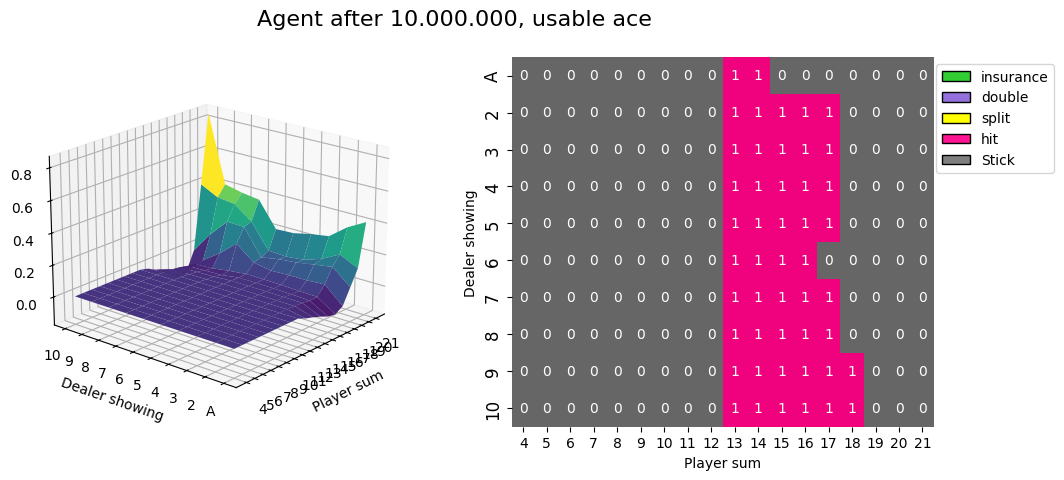

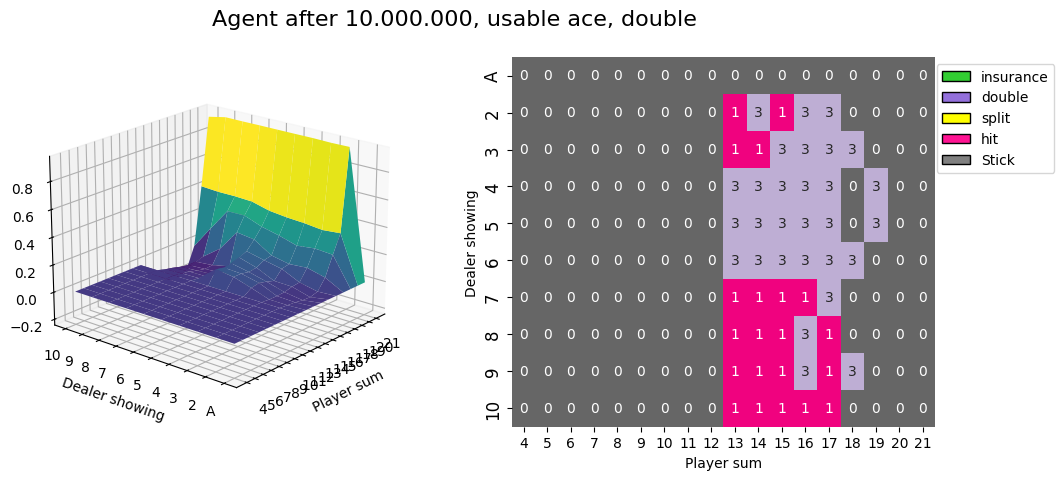

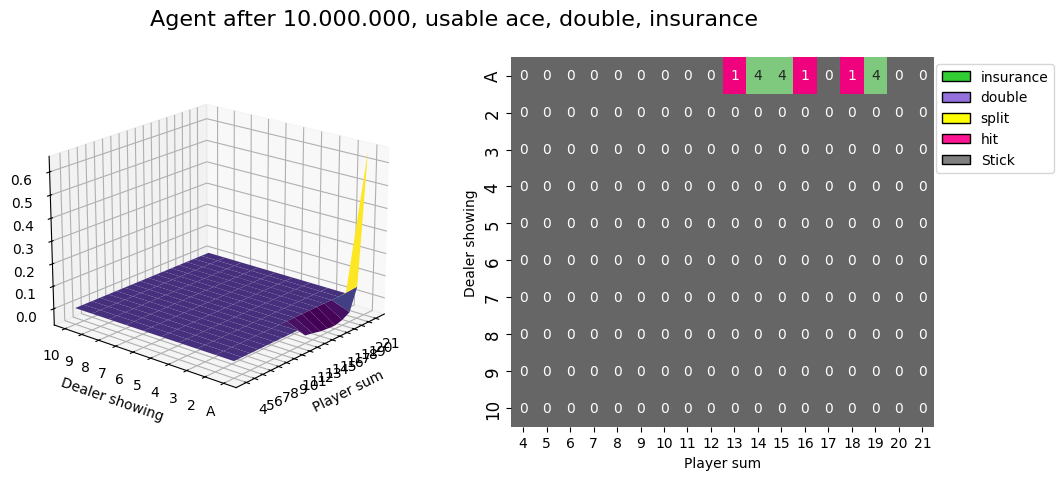

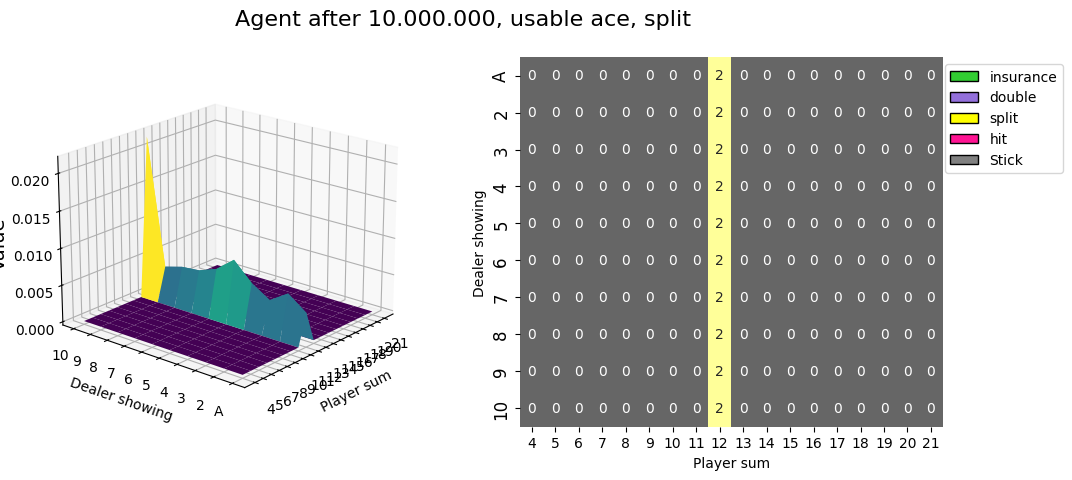

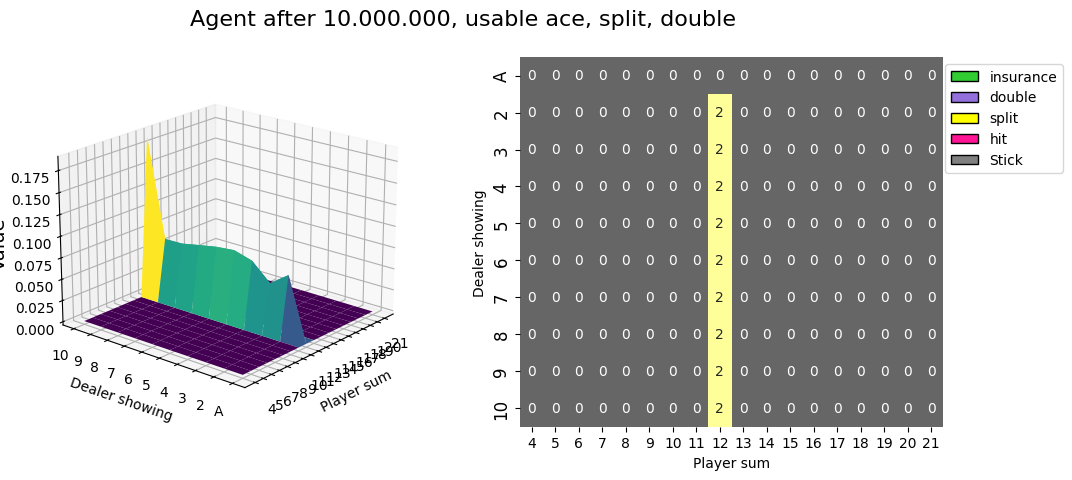

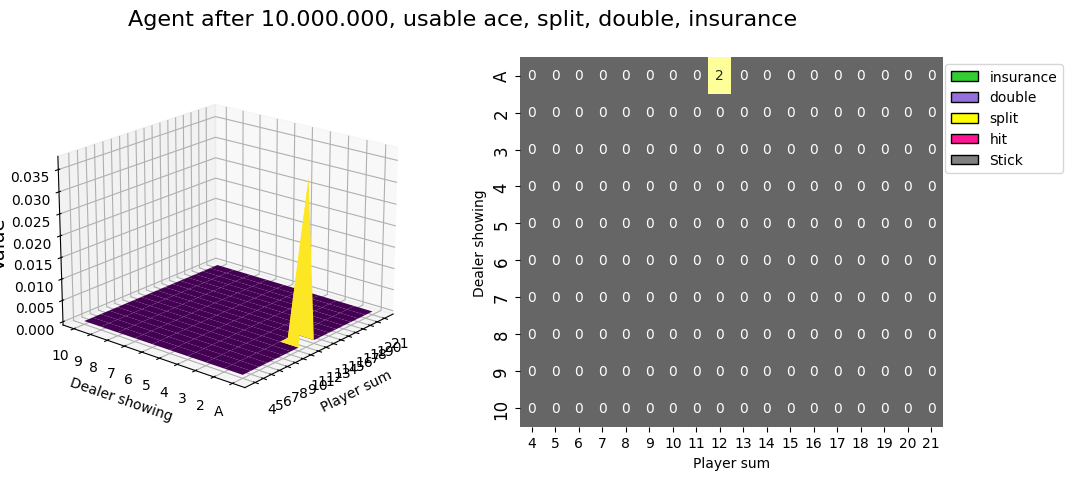

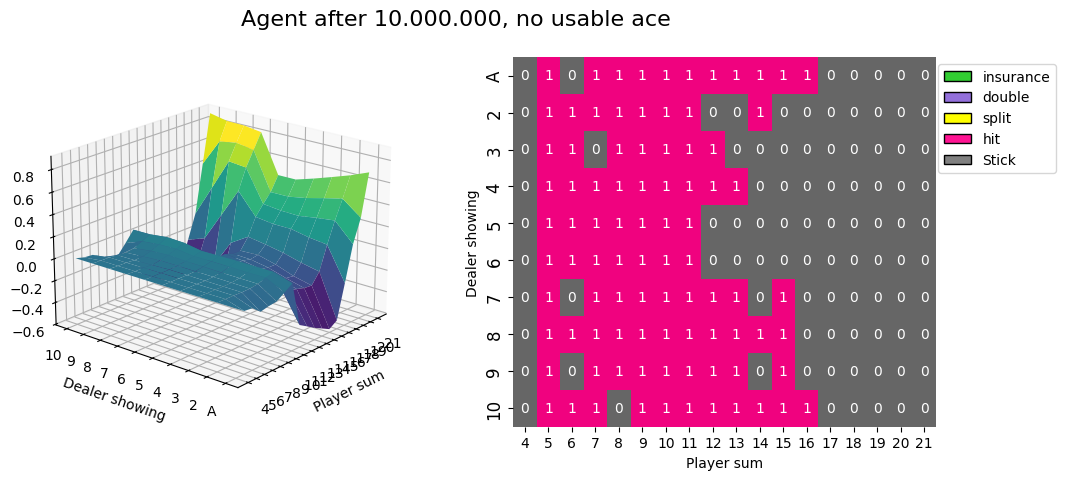

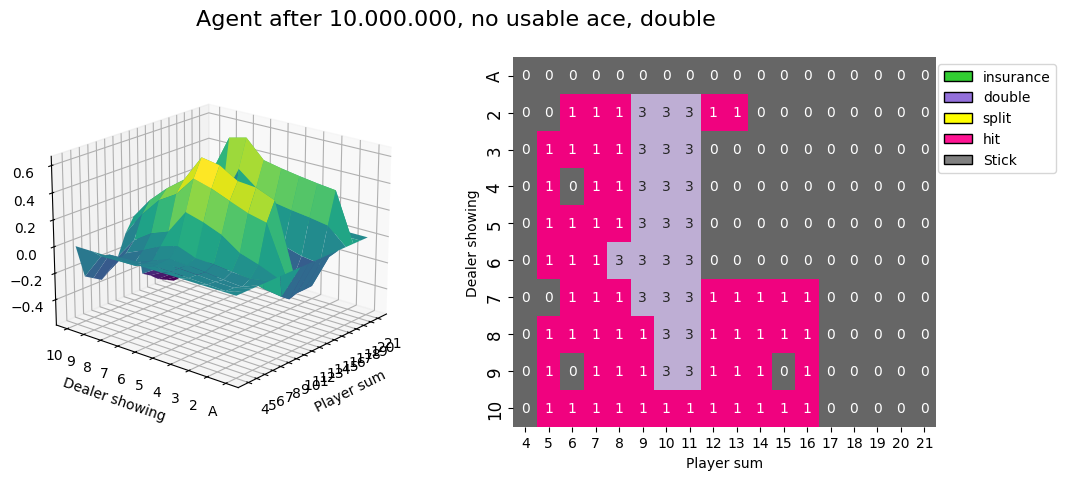

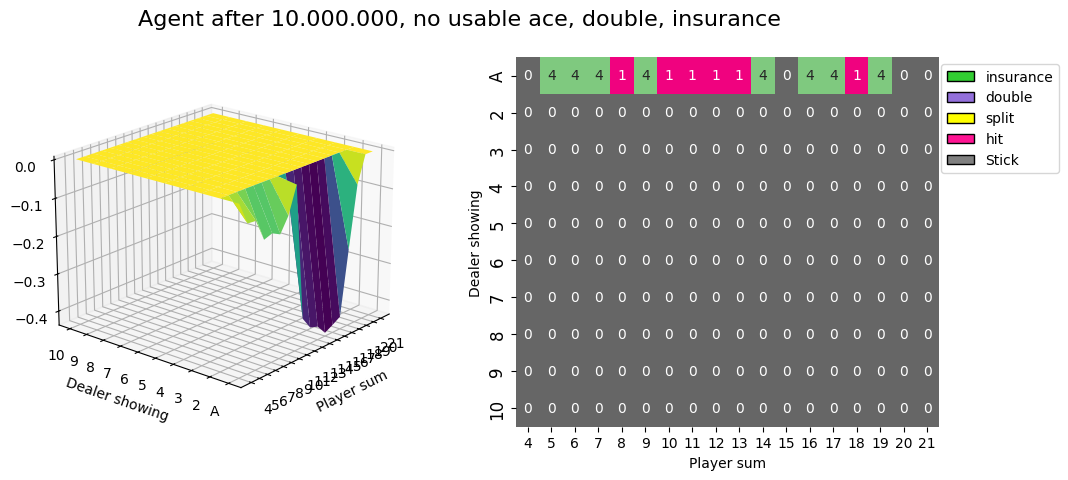

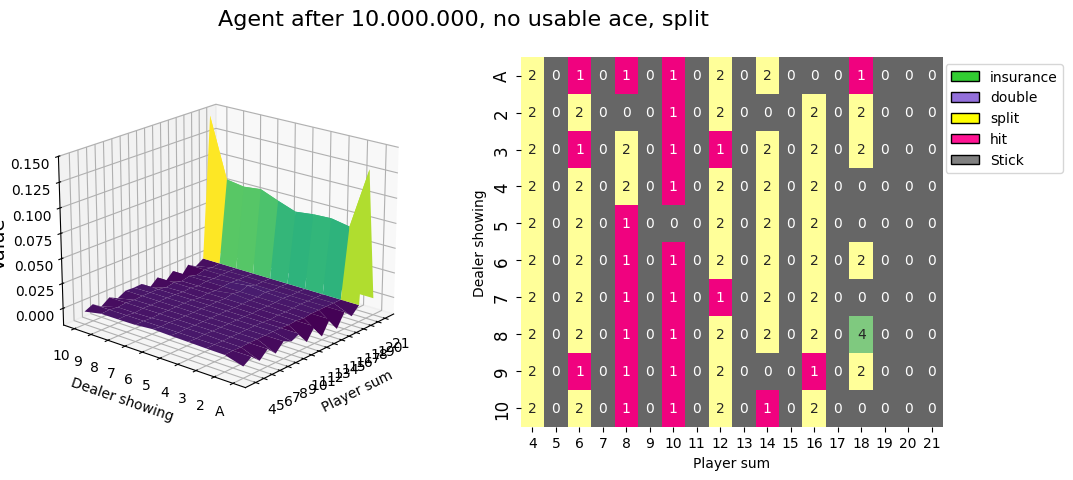

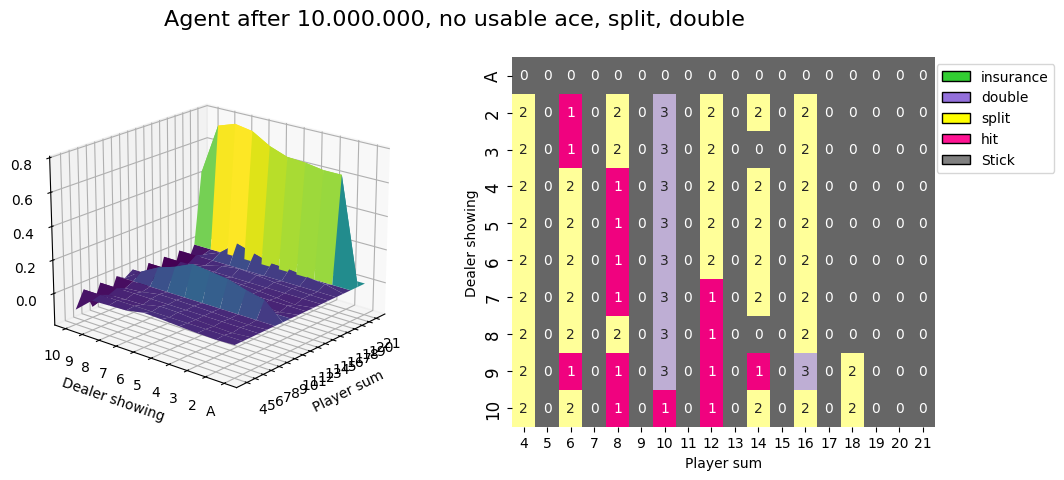

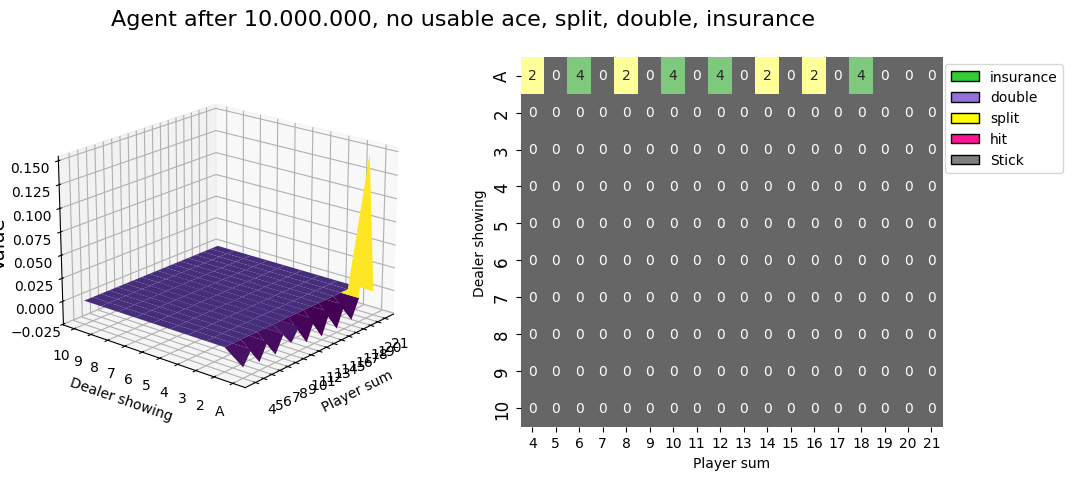

In [58]:
legend_elements = [
    Patch(facecolor="limegreen", edgecolor="black", label="insurance"),
    Patch(facecolor="mediumpurple", edgecolor="black", label="double"),
    Patch(facecolor="yellow", edgecolor="black", label="split"),
    Patch(facecolor="deeppink", edgecolor="black", label="hit"),
    Patch(facecolor="grey", edgecolor="black", label="Stick"),
]                                                                       

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(True, False, False, False))
fig1 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, usable ace", legend_elements = legend_elements)
plt.show()

value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(True, False, True, False))
fig5 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, usable ace, double", legend_elements = legend_elements)
plt.show()

value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(True, False, True, True))
fig13 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, usable ace, double, insurance", legend_elements = legend_elements)
plt.show()

# state values & policy with usable ace (ace counts as 11) and split
value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(True, True, False, False))
fig3 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, usable ace, split", legend_elements = legend_elements)
plt.show()

value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(True, True, True, False))
fig7 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, usable ace, split, double", legend_elements = legend_elements)
plt.show()

value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(True, True, True, True))
fig15 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, usable ace, split, double, insurance", legend_elements = legend_elements)
plt.show()

# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(False, False, False, False))
fig2 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, no usable ace", legend_elements = legend_elements)
plt.show()

value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(False, False, True, False))
fig6 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, no usable ace, double", legend_elements = legend_elements)
plt.show()

value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(False, False, True, True))
fig14 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, no usable ace, double, insurance", legend_elements = legend_elements)
plt.show()

# state values & policy without usable ace (ace counts as 1) and split
value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(False, True, False, False))
fig4 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, no usable ace, split", legend_elements = legend_elements)
plt.show()

value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(False, True, True, False))
fig8 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, no usable ace, split, double", legend_elements = legend_elements)
plt.show()

value_grid, policy_grid = create_grids(agent_evolution_fourth[2], booleans=(False, True, True, True))
fig16 = create_plots(value_grid, policy_grid, title=f"Agent after 10.000.000, no usable ace, split, double, insurance", legend_elements = legend_elements)
plt.show()

With so many graphs the analysis will become a bit choppy, this is because the grids will present some holes that can actually be found elsewhere. If you have not understood what I mean, read on for a better explanation. I will start by taking all the cases where the ace is worth 11 and then those where it is worth 1.


1) After 10,000,000 episodes, if there is no possible action beyond hit and stay, the agent behaves as in the first 3 environments with a few more holes here and there. This is due because this case never happens in the first hand, but in the second. In fact the row of 12 (A-A) is all 0, this is because in the third hand it is impossible to sum to 12 with 3 cards. also when the dealer shows an A there are some “misses”. Beyond this he manages to get good results since from the graph on the left there are positive values, except when the dealer shows a high card which always involves some risk. Let's try to see how he performs with the double, then the first hand: the value graph jumps out immediately, ignoring the high spikes that are due to 21, he holds good high values and some low values always due to high cards from the dealer. Looking at the grid he likes to double most of the cards IF the dealer presents low value cards, because the moment the dealer's card value increases he prefers to hit or even stay of the case presents an A. But is this really the case? If we consider the next graph, then available doubling and available insurance, we find the whole ace row missing in the previous graph. This is because in the first hand, so that is why the first chart had no lack in the ace row, if the dealer shows an ace you can take insurance or double (or hit or stay). From the grid there does not seem to be a recurring or logical pattern coming out in any way while from the value chart there is a slight negative value (and always a spike to 21 that we ignore) but we like it. Because it means that by taking the insurance the agent is able to limit the blackjack problem on the part of the dealer or perhaps, simply the value is negative due to the reward that is received if the insurance is not successful, which in our case corresponds to -0.2. However, we are missing the entire column that corresponds to the value 12, and we complete it by moving on to the case of the presence of splits thanks to first-hand A-A. So, since we are in the first hand, all 3 additional actions are available. Despite the great choice, the action that the agent prefers is the split, in fact it appears in massive presence on all occasions. With this we have concluded the analysis of the ace which is worth 11.
2) Now, following the order of the graphs, in the first we only have the option to hit or stay. We are not in the first hand but in the subsequent ones and as in the previous graphs the first column which corresponds to 4 will not be present due to the impossibility of adding 4 with 3 cards. The results align with the first 3 environments, with some holes here and there which I expect due to the randomness of the environment or how the agent found it better to play after 10 million games. If, however, we look at how he behaves in the first hand when doubling or insurance are allowed (the split will be observed later), we always notice that the agent likes to double the 10 and 11, he also allows himself to do so with the 9 and 8 if the dealer has a medium-low card. As regards high or low values, he does not double but asks for a card, this is because at low values ​​you risk being stuck with a low value and at high values ​​you risk jumping beyond 21. We have that the agent approaches the suggestions of the strategy fundamental. Here too the 4 column and the ace row are missing. But as in the previous case, we find the ace row with insurance which is a very valid option for the agent even if in the value grid we only find negative values. If the agent takes these actions it is because he prefers to lose a little rather than lose big. Let's now move on to the analysis of the split, where we find the row of the sum of 4, which is always divided to play 2 hands together with many other values. He never divides 5s or even 10s, in the first case he will have learned something that brought him to this point in the second, as already said, it is an unwritten rule never to divide 10s. Every now and then in this graph it happens to find values ​​of invalid actions, this is due to the randomness of how events happen which can lead to negative rewards more often and therefore an invalid action can be the best choice but only because it has not been punished sufficiently on this specific event. If in addition to splitting there is doubling, he prefers to double on 10, in line with the case above where there was doubling, and every now and then he seems to double high values ​​without logical sense. As with the others, we lack insurance. Insurance which is sometimes ignored in favor of doubling but other times is chosen. Again, I don't find a logical pattern for how the agent makes these decisions. As regards the value grid of the latest graphs, they all remain in line with the axis graphs, low earnings for infrequent actions and the same shapes repeating between the various cases.

Conclusion: the environment has become a union of a lot of possible states and actions that no longer needs to be analyzed point by point but must be mixed to better understand how the agent came to choose. From my analyzes of repeated executions, even in this environment the agent manages to replicate, with more difficulty, the results of the fundamental strategy. We have reached the conclusion of the analyzes of this notebook, personally speaking I am satisfied with my results. Although very chaotic to understand at first glance, the agent performed well in almost all environments and reached the threshold of good results, managing to replicate the fundamental strategy almost perfectly. If we had no mathematical basis to understand the statistic that led to the tables recommending safe play, we now have another way to replicate it. Of course not as meticulously as the numbers would.

The agent after 100000 achieve: 4270 win, 4784 lose and 946 draw 

The agent after 1000000 achieve: 4323 win, 4711 lose and 966 draw 

The agent after 10000000 achieve: 4224 win, 4846 lose and 930 draw 



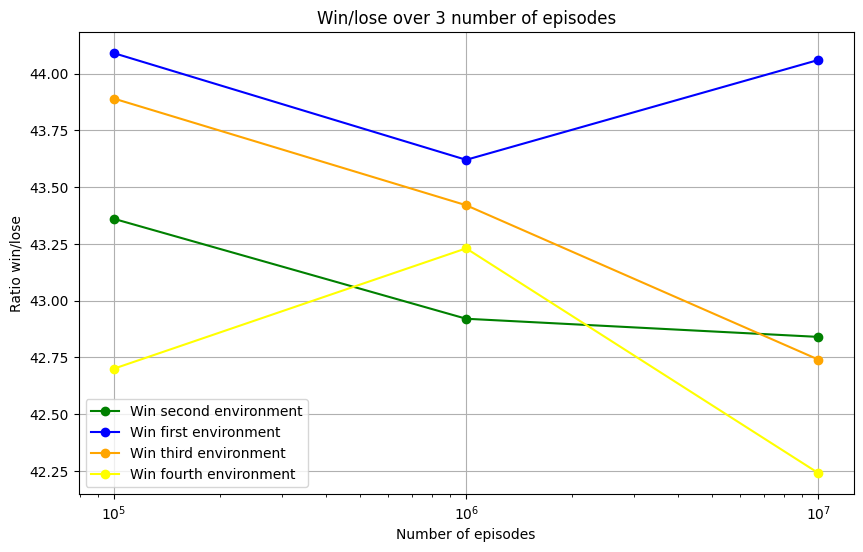

In [59]:
for i, win in enumerate(win_lose_fourth):
    print(f"The agent after {time_stamp[i]} achieve: {win[0]} win, {win[1]} lose and {10000-win[0]-win[1]} draw \n")

wins_fourthEnvironment = [item[0]/100 for item in win_lose_fourth]

plt.figure(figsize=(10, 6))
plt.plot(games, wins_secondEnvironment, label='Win second environment', marker='o', linestyle='-', color='green')
plt.plot(games, wins_firstEnvironment, label='Win first environment', marker='o', linestyle='-', color='blue')
plt.plot(games, wins_thirdEnvironment, label='Win third environment', marker='o', linestyle='-', color='orange')
plt.plot(games, wins_fourthEnvironment, label='Win fourth environment', marker='o', linestyle='-', color='yellow')

plt.xlabel('Number of episodes')
plt.ylabel('Ratio win/lose')
plt.title('Win/lose over 3 number of episodes')
plt.legend()

plt.grid(True)
plt.xscale('log')
plt.show()

As for the other three, the agent's goodness index shows that the fourth agent manages to approach the same range of victories. Again through different executions, I noticed that the more the complexity of the environment increases, the more the win rate drops, indicating a difficulty for the agent using q_learning to keep up with an increase in the state space.

# More environment

Modern blackjack comes with side bet: side bets are additional bets that players get the chance to play in online blackjack. These can be presented at the beginning of the round and can be on the outcome of the initial draw or the overall hand, or they can be offered to the player during the hand, depending on how it is being played. A side bet, like all bets in blackjack, is based completely on luck, and does not reduce the house edge in the game in any way. Most blackjack tips recommend against the use of side-bet. Each type of side bet brings its own additional risks and rewards, and it is important players weigh these up and consider their blackjack strategies before making a decision.

Most popular side bet include:
 - 21+3
 - Perfect pair
 - Insurance (yes, it's considered a side bet)
 - and so on..


Check [gamblingzone](https://www.gamblingzone.com/uk/blackjack/side-bet/) for the definition written above and know more about specific side bet.

***I choose not to implement the side bet for time purpose, maybe I will come back later and finish the job. For now I think of leaving these 4 environments and studying the results obtained to get the best from the agent.***